<a id = "project_overview"></a>
# <u>Project Overview</u>

**TEAM 2:** Jaime Jiang, Xiaosong Yu, Evgeny Golubitskiy, Aditri Tewari, Allison Lee, Thaochau Phan

## I. Goals:

Our data project will focus on evaluating mental health trends within the technology sector. Mental health is an often stigmatized, overlooked subject, and when employees are placed within a fast-paced, high-stress work culture (one that the technology sector is often notorious for), their mental health can suffer dramatically if the issue is left undiscussed or undiagnosed. Thus, our analysis seeks to explore the following questions:

- How frequently are mental health services provided to employees among technology companies?
- What is the impact of untreated mental health issues on employees' work productivity?
- Is there a difference between respondents' willingness to discuss mental versus physical health?
- Is there a correlation between mental health and location in which employees work, either by country or U.S states?

In addition, we applied machine learning to:

- Identify key sets of features where respondents may differ with regards to the topic of mental health (feature selection)
- Build a predictive model for identifying individuals with mental health

## II. Data Inputs:

Our project utilizes data from the Open Sourcing Mental Illness's (OSMI) annual Mental Health in Tech survey from the period 2016 to 2019. The list of survey questions asked of each participant can be found under Appendix A.
- Link to raw input files: https://osmihelp.org/research

## II. Table of Contents:

[Preparation: Install Necessary Libs and Solve the file path issue.](#prep)

[I. Data Cleaning](#data_cleaning)

[II. Summary of Respondents' Demographic Characteristics](#summ_demo_char)

[III. How frequently are mental health services provided to employees among technology companies?](#freq_mh_provided)

[IV. What is the impact of untreated mental health issues on employees' work productivity?](#impact_mh)

[V. Is there a difference between respondents' willingness to discuss mental versus physical health?](#diff_phys_ment_disc)

[VI. Is there a correlation between mental health and location in which employees work, either by country or U.S states?](#corr_mh_loc)

[VII. Feature Selection Using K-Modes Clustering](#kmodes_clust)


[VIII. Predictive Modeling of Mental Health Status Using Machine Learning](#mh_pred_model)


[Appendix A](#appendix_a)



<a id = "prep"></a>
## Preparation: Install Necessary Libs and Solve the file path issue.

[Back to Project Overview](#project_overview)

In [1]:
 # The GeoPandas map file is too large for Github to offer a public link, so we have to use Google Drive and mount the drive for access

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Install GeoPandas
!pip install geopandas

     |████████████████████████████████| 931kB 3.3MB/s 
     |████████████████████████████████| 10.4MB 38.4MB/s 
     |████████████████████████████████| 14.7MB 307kB/s 


In [3]:
# Install Fuzzywuzzy
!pip install fuzzywuzzy

In [4]:
# Instal KModes
!pip install kmodes

# <u>Data Analysis</u>


<a id = "data_cleaning"></a>
## I. Data Cleaning:

[Back to Project Overview](#project_overview)

a) Import relevant python packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from IPython.display import HTML
import geopandas as gpd
from shapely.geometry import Point, Polygon
import warnings
from kmodes.kmodes import KModes
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#turn off display of warning messages
warnings.filterwarnings('ignore')
#show all columns in table
pd.options.display.max_columns = None

b) Read in raw input files from across all years in the study period.

In [2]:
#read in raw data for each survey year
osmi2016_df = pd.read_csv("https://github.com/xsyu6/OSMI-16-19/raw/master/OSMI_2016.csv")
osmi2017_df = pd.read_csv("https://github.com/xsyu6/OSMI-16-19/raw/master/OSMI_2017.csv")
osmi2018_df = pd.read_csv("https://github.com/xsyu6/OSMI-16-19/raw/master/OSMI_2018.csv")
osmi2019_df = pd.read_csv("https://github.com/xsyu6/OSMI-16-19/raw/master/OSMI_2019.csv")

#define starting year
osmi_start_yr = 2016
#define ending year
osmi_end_yr = 2019
#generate a list of all survey years
osmi_years_lst = [year for year in range(osmi_start_yr, osmi_end_yr+1)]

#create variables containing a list of column names for each survey data year 
for year in osmi_years_lst:
    exec("osmi" + str(year) + "_colnames = list(osmi" + str(year) + "_df.columns)")

c) The survey data for each year contains column names that vary slightly in their phrasing or use of punctuation marks, making it difficult to fully concatenate the survey data together and align each column properly. Furthermore, because of the large number of columns that each dataset possesses, manually evaluating the phrasing of each column to identify and group similar columns is not an option. To overcome this issue, we will use a fuzzy matching algorithm to identify the columns with similar phrasing for grouping. To limit the potential of grouping dissimilar columns, we will only use columns that have a fuzzy match of at least 95% (i.e. the columns are at least 95% similar to one another). Furthermore, we will limit to using only columns that are present in all four years of survey data (2016-2019).

---

i. Calculate a dataframe of fuzzy match ratio for each column combination across all year of survey data.

In [3]:
#initialize dataframe that will contain results of fuzzy matching procedure
fuzzy_ratio_df = pd.DataFrame(columns = ["BASE_YEAR", "COMPARISON_YEAR", "BASE_COLNAME", "COMPARISON_COLNAME", "FUZZY_RATIO"])
for base_year in osmi_years_lst:
    
    #find the index associated with the base year
    base_year_ind = osmi_years_lst.index(base_year)
    #get the list of column names for the given base year
    exec("base_year_lst = osmi" + str(base_year) + "_colnames" )
    
    inter_osmi_years_lst = osmi_years_lst.copy()
    inter_osmi_years_lst.remove(base_year)
    for next_year in inter_osmi_years_lst:
        
        #get the list of column names for the next year
        exec("next_year_lst = osmi" + str(next_year) + "_colnames")
        
        #find all combinations of column names between the base year column name list and the next year column name list
        colname_combos = np.array([(base_year_lst[b_ind], next_year_lst[n_ind]) for b_ind, b_yr in enumerate(base_year_lst) for n_ind, n_yr in enumerate(next_year_lst)])
        
        fuzzy_ratio_lst = [] #initialize fuzzy ratio list
        #run fuzzy matching to identify similar column names across the years of survey data
        for combo in colname_combos:
            str1, str2 = combo[0], combo[1]
            fuzzy_ratio = fuzz.token_set_ratio(str1, str2) 
            fuzzy_ratio_lst.append(fuzzy_ratio)
            
        #store results of fuzzy matching into dataframe
        intermediate_df = pd.DataFrame({"BASE_YEAR": np.full((len(colname_combos), ), base_year), \
                                        "COMPARISON_YEAR": np.full((len(colname_combos), ), next_year), \
                                        "BASE_COLNAME": colname_combos[:, 0], \
                                        "COMPARISON_COLNAME": colname_combos[:, 1], \
                                        "FUZZY_RATIO": fuzzy_ratio_lst})
        fuzzy_ratio_df = fuzzy_ratio_df.append(intermediate_df, ignore_index = True)
        
#sort fuzzy matching dataframe to show column combinations with highest fuzzy matching ratio at the top
fuzzy_ratio_df = fuzzy_ratio_df.sort_values(by = ["BASE_YEAR", "COMPARISON_YEAR", "BASE_COLNAME", "FUZZY_RATIO"], \
                                            ascending = [True, True, True, False])

#display initial rows
fuzzy_ratio_df.head(10)

,BASE_YEAR,COMPARISON_YEAR,BASE_COLNAME,COMPARISON_COLNAME,FUZZY_RATIO
1,2016,2017,Are you self-employed?,<strong>Are you self-employed?</strong>,100
93,2016,2017,Are you self-employed?,"If you have a mental health disorder, how ofte...",50
100,2016,2017,Are you self-employed?,Are you openly identified at work as a person ...,50
30,2016,2017,Are you self-employed?,<strong>Do you have previous employers?</strong>,48
58,2016,2017,Are you self-employed?,Stress Response Syndromes,48
71,2016,2017,Are you self-employed?,Stress Response Syndromes.1,46
84,2016,2017,Are you self-employed?,Stress Response Syndromes.2,46
91,2016,2017,Are you self-employed?,Do you have a family history of mental illness?,45
3,2016,2017,Are you self-employed?,Is your employer primarily a tech company/orga...,43
112,2016,2017,Are you self-employed?,What is your age?,43


ii. Limit to column names that have a fuzzy match ratio of at least 95% and occurs in all 4 years of survey data.

In [4]:
#subset to the combinations with the highest fuzzy ratio (i.e. the combination of column names that is most similar)
highest_fuzzy_matches_df = fuzzy_ratio_df.groupby(["BASE_YEAR", "COMPARISON_YEAR", "BASE_COLNAME"]).first().reset_index()

#subset to records with fuzzy matching ratio above or equal to 95
top95_fuzzy_ratio_df = highest_fuzzy_matches_df[highest_fuzzy_matches_df["FUZZY_RATIO"] >= 95]

#using records from the OSMI start year, count the number of years that the column name (or its fuzzy match similar) appears in 
num_colname_occur = top95_fuzzy_ratio_df[top95_fuzzy_ratio_df["BASE_YEAR"] == osmi_start_yr].groupby(["BASE_COLNAME"]).aggregate({"COMPARISON_YEAR": "nunique"})
num_colname_occur = num_colname_occur.reset_index()
num_colname_occur = num_colname_occur.rename(columns = {"COMPARISON_YEAR": "NUM_YEARS_OCCUR"})

#flag if the column name does not occur in all subsequent years after the starting OSMI year
num_colname_occur["OCCUR_IN_ALL_YEARS_FLG"] = np.where(num_colname_occur["NUM_YEARS_OCCUR"] == osmi_end_yr - osmi_start_yr, 1, 0)

#subset to final list of column names that have fuzzy matching ratio above 95 and occurs in all all years
fin_colname_df = num_colname_occur[num_colname_occur["OCCUR_IN_ALL_YEARS_FLG"] == 1][["BASE_COLNAME"]]

#show final columns list
fin_colname_df

,BASE_COLNAME
0,Are you self-employed?
1,Did your previous employers ever formally disc...
2,Did your previous employers provide resources ...
3,Do you believe your productivity is ever affec...
4,Do you currently have a mental health disorder?
5,Do you have a family history of mental illness?
6,Do you have previous employers?
7,Do you know local or online resources to seek ...
8,Do you know the options for mental health care...
11,Does your employer offer resources to learn mo...


iii. Standardize the column names so that they all have the same phrasing going forward for each year of survey data. Next, concatenate the survey data into a single master dataset.

In [5]:
#loop through the survey data for each year and standardize the column name so that the column name is renamed to what is in the starting year OSMI data
for colname in fin_colname_df["BASE_COLNAME"]:
    colname_subdf = highest_fuzzy_matches_df[highest_fuzzy_matches_df["BASE_COLNAME"] == colname]
    for year in osmi_years_lst[1:]:
        year_comparison_name = colname_subdf[colname_subdf["COMPARISON_YEAR"] == year]["COMPARISON_COLNAME"].values[0]
        exec("osmi" + str(year) + "_df" + " = osmi" + str(year) + "_df.rename(columns = {'" + year_comparison_name + "':'" + colname + "'})")

fin_colname_lst = list(fin_colname_df["BASE_COLNAME"])
#manually remove this column (had difficulty reading this column in)
fin_colname_lst.remove('Why or why not?.1')
fin_colname_lst.remove('Why or why not?')

#create final master dataset that contains only the columns that occur across all years
osmi_df_to_concat = []
for year in osmi_years_lst:
    exec("cur_df = osmi" + str(year) + "_df[fin_colname_lst].copy()")
    cur_df["SURVEY_YEAR"] = year
    osmi_df_to_concat.append(cur_df)
final_osmi_df = pd.concat(osmi_df_to_concat);

#display first few rows of final master dataset
final_osmi_df.head(10)

,Are you self-employed?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Do you believe your productivity is ever affected by a mental health issue?,Do you currently have a mental health disorder?,Do you have a family history of mental illness?,Do you have previous employers?,Do you know local or online resources to seek help for a mental health disorder?,Do you know the options for mental health care available under your employer-provided coverage?,Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Does your employer provide mental health benefits as part of healthcare coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Have you ever sought treatment for a mental health issue from a mental health professional?,Have you had a mental health disorder in the past?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,Have your previous employers provided mental health benefits?,How many employees does your company or organization have?,How willing would you be to share with friends and family that you have a mental illness?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:","If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?",Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Were you aware of the options for mental health care provided by your previous employers?,What US state or territory do you live in?,What US state or territory do you work in?,What country do you live in?,What country do you work in?,What is your age?,What is your gender?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up a mental health issue with a potential employer in an interview?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,SURVEY_YEAR
0,0,I don't know,None did,NaN,No,No,1,NaN,NaN,No,Not eligible for coverage / N/A,No,0,Yes,No,NaN,"No, none did",26-100,Somewhat open,Very easy,NaN,Not applicable to me,Not applicable to me,NaN,NaN,I don't know,1,NaN,I don't know,N/A (not currently aware),NaN,NaN,United Kingdom,United Kingdom,39.0,Male,Maybe,Maybe,Maybe,Yes,Some of my previous employers,2016
1,0,None did,Some did,NaN,Yes,Yes,1,NaN,Yes,Yes,No,Yes,1,Yes,No,NaN,"Yes, they all did",6-25,Somewhat open,Somewhat easy,NaN,Somet

iv) Below is a distribution of fuzzy match values. The plots show that the majority of column combinations have above 95% fuzzy match, and we are not losing a significant number of columns by limiting to only columns that meet this threshold:

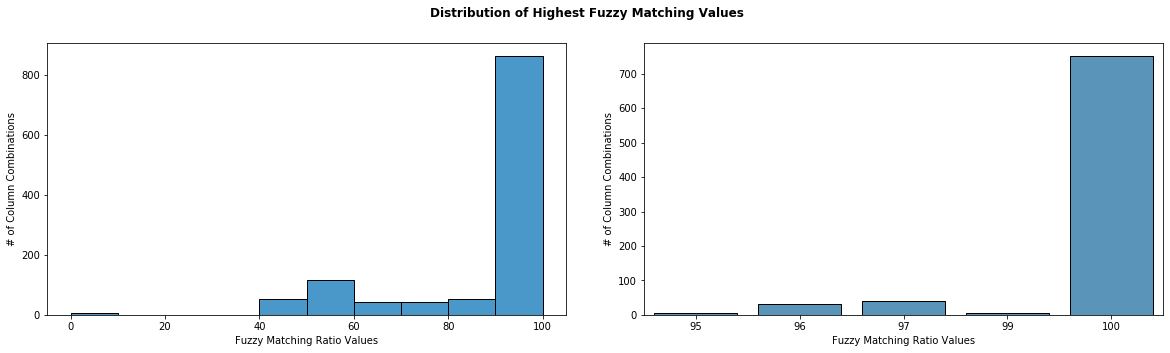

In [6]:
#initialize subplots
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
fig.subplots_adjust(wspace = 0.15) #adjust spacing between subplots
#add figure title
fig.suptitle("Distribution of Highest Fuzzy Matching Values", y = 0.98, fontweight = "bold", fontsize = 12)

#plot histogram of the highest fuzzy ratio values
ax[0].hist(highest_fuzzy_matches_df["FUZZY_RATIO"], edgecolor = "black", color = plt.cm.Blues(0.6))
ax[0].set_xlabel("Fuzzy Matching Ratio Values")
ax[0].set_ylabel("# of Column Combinations")

#plot count plot of fuzzy ratio for records with fuzzy ratio values above 95
sns.countplot(x = "FUZZY_RATIO", data = top95_fuzzy_ratio_df, ax = ax[1], edgecolor = "black", color = plt.cm.Blues(0.6))
ax[1].set_xlabel("Fuzzy Matching Ratio Values")
ax[1].set_ylabel("# of Column Combinations")

plt.show();

d) Survey respondents answered the question regarding their gender in varying ways, so we will standardize the values for the inputted gender into 3 categories: male, female, and other.

In [7]:
#categorize the following responses as 'male'
male_responses = ['male', 'm', 'man', 'cis male','male.', 'male (cis)', 'sex is male', \
                  'malr', 'dude', \
                  "i'm a man why didn't you make this a drop down question. you should of asked sex? and i would of answered yes please. seriously how much text can this take? ", \
                  'mail', 'm|', 'male (trans, ftm)', 'cisdude', 'cis man', 'male / gender queer', 'cis-male', \
                  'male/androgynous', 'cisheteromale', "male (hey this is the tech industry you're talking about)", \
                  'male,cis', 'male-ish', 'ostensibly male', 'male, born with xy chromosoms', 'malel', 'cisgendermale', \
                  'let\'s keep it simple and say "male"', 'identify as male', 'masculine', 'cishetmale', 'i have a penis', \
                  'masculino', 'make', 'demiguy', 'nb masculine', 'transman']

#remove all spacing from strings
male_responses = [resp.replace(" ", "") for resp in male_responses]

#categorize the following responses as 'female'
female_responses = ['female', 'i identify as female.', 'female assigned at birth ', 'f', 'woman', 'fm', \
                    'cis female', 'transitioned, m2f', 'female or multi-gender femme', \
                    'woman', 'female/woman', 'cisgender female', \
                    'mtf', 'fem', 'female (props for making this a freeform field, though)', \
                    'cis-woman', 'afab', 'transgender woman', 'female (cis)', 'gender queer woman', \
                    'female-bodied; no feelings about gender', 'femalw', 'femail', 'uhhhhhhhhhfemgenderqueer?', \
                    'mysexisfemale.', 'female(cisgender)', 'woman-identified', 'cis-female', 'f,cisgender', 'female-ish', \
                    'female/gendernon-binary.', 'ciswoman', 'cisgenderedwoman', 'she/her/they/them', 'nonbinary/femme', \
                    'gender non-conforming woman', 'female-identified', 'femmina', 'femile', 'genderfluid(bornfemale)', \
                    'i identify as female', '*shrug emoji* (f)', 'transfemale', 'agendertranswoman', 'genderqueerdemigirl', \
                    'transwoman', 'transfeminine']

#remove all spacing from strings
female_responses = [resp.replace(" ", "") for resp in female_responses]

#lower case and remove all spacing from responses
final_osmi_df["What is your gender?"] = final_osmi_df["What is your gender?"].str.lower().str.replace(" ", "")
#replace values with either male or female
final_osmi_df["What is your gender?"] = final_osmi_df["What is your gender?"].replace(male_responses, "Male")
final_osmi_df["What is your gender?"] = final_osmi_df["What is your gender?"].replace(female_responses, "Female")
#set all other responses to 'other'
final_osmi_df["What is your gender?"] = np.where(final_osmi_df["What is your gender?"].isin(["Male", "Female"]) == False, \
                                                 "Other", \
                                                 final_osmi_df["What is your gender?"] )

e) Rename columns to an abbrevatied variable name.

In [8]:
# Rename all columns for short abbreviations, assign them with new dataframe: raw_renamedcols
final_osmi_df = final_osmi_df.rename({'Are you self-employed?':'Selfemploy',
                              'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?':'PreEplyrFormalDiscussed',
                              'Did your previous employers provide resources to learn more about mental health issues and how to seek help?':'PreEplyrProvidedResourceToLearn',
                              'Do you believe your productivity is ever affected by a mental health issue?':'ProductivityAffected',
                              'Do you currently have a mental health disorder?':'CurrentStatusMHD',
                              'Do you have a family history of mental illness?':'FamilyHistory',
                              'Do you have previous employers?':'HavePreEplyr',
                              'Do you know local or online resources to seek help for a mental health disorder?':'ResourceAwareness',
                              'Do you know the options for mental health care available under your employer-provided coverage?':'EplyrCoverageOptionsAwareness',
                              'Does your employer offer resources to learn more about mental health concerns and options for seeking help?':'EplyrProvideResourceToLearn',
                              'Does your employer provide mental health benefits as part of healthcare coverage?':'EplyrProvideBenefitsInCoverage',
                              'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?':'EplyrFormalDiscussed',
                              'Have you ever sought treatment for a mental health issue from a mental health professional?':'HistorySeekTreatMHPro',
                              'Have you had a mental health disorder in the past?':'PastHistoryMHD',
                              'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?':'UnsupportiveObs&Exp',
                              'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?':'ObsLedUnwillingness',
                              'Have your previous employers provided mental health benefits?':'PreEplyrProvidedBenefits',
                              'How many employees does your company or organization have?':'EplyeeNumber',
                              'How willing would you be to share with friends and family that you have a mental illness?':'ShareFFWillingness',
                              'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:':'AskLeaveFromWork',
                              'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?':'AffectedWorkTime',
                              'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?':'InterfereWorkWhenTreatedEffectivelyNo',
                              'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?':'InterfereWorkWhenTreatedEffectivelyYes',
                              'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?':'RevealToClientsContacts',
                              'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?':'RevealToCoworkersEplyees',
                              'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?':'AnonymityProtectedEplyr',
                              'Is your employer primarily a tech company/organization?':'EplyrTechOrNot',
                              'Is your primary role within your company related to tech/IT?':'RoleITOrNot',
                              'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?':'AnonymityProtectedPreEplyr',
                              'Were you aware of the options for mental health care provided by your previous employers?':'PreEplyrOptionsAwareness',
                              'What US state or territory do you live in?':'LiveUSTerritories',
                              'What US state or territory do you work in?':'WorkUSTerritories',
                              'What country do you live in?':'LiveCountries', 
                              'What country do you work in?':'WorkCountries',
                              'What is your age?':'Age', 
                              'What is your gender?':'Gender',
                              'Would you be willing to bring up a physical health issue with a potential employer in an interview?':'InterviewReleasePhysicalWillingness',
                              'Would you bring up a mental health issue with a potential employer in an interview?':'InterviewReleaseMentalWillingness',
                              'Would you feel comfortable discussing a mental health disorder with your coworkers?':'ComfortDiscussWCoworkers',
                              'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?':'ComfortDiscussWSupervisor',
                              'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?':'BeWillingDiscussWSupervisor',
                              'SURVEY_YEAR':'Year'}, 
                              axis='columns')

f) Create an identifier number for each respondent's answers:

In [9]:
#create a response identifier column
final_osmi_df["RESPONSE_ID"] = final_osmi_df.index + 1

<a id = "summ_demo_char"></a>
## II. Summary of Respondents' Demographic Characteristics:

[Back to Project Overview](#project_overview)

Before delving deeper into our data to identify key relationships among the survey variables, we wanted to get a general sense of who our survey respondents were. Thus, this section focuses on reviewing the demographic characteristics of the individuals who responded to the OSMI survey. Specifically, we look at the following demographic characteristics:

- Gender
- Company Size
- Age
- Location Where Respondents Work by Country and U.S States
- Self-employment Status

**KEY TAKEAWAYS:**

- The majority of respondents (~65% of respondents) were male.
- Most respondents were employed at either a medium-sized (25-100) or large-sized (100+) organizations.
- The majority of clients are in their mid-30s. 
- Most respondents were from within the United States.
- Most respondents were not self-employed.
- The lack of range or representations of female employees, older employees, and international technology companies may limit our model's ability to accurately make predictions and generalizations in the following sections.

---

a) Calculate count of respondents by gender.

In [10]:
#count the number of respondents by year and gender
resp_cnt_by_gender_yr = final_osmi_df.groupby(["Year", "Gender"]).aggregate({"RESPONSE_ID": "count"}).reset_index()
#rename column
resp_cnt_by_gender_yr = resp_cnt_by_gender_yr.rename(columns = {"RESPONSE_ID": "# of Respondents"})
#calculate gender proportion for each year
resp_cnt_by_gender_yr["% of Respondents"] = 100 * resp_cnt_by_gender_yr["# of Respondents"]/resp_cnt_by_gender_yr.groupby("Year")["# of Respondents"].transform("sum")
#display result
resp_cnt_by_gender_yr

,Year,Gender,# of Respondents,% of Respondents
0,2016,Female,346,24.145150
1,2016,Male,1060,73.970691
2,2016,Other,27,1.884159
3,2017,Female,224,29.629630
4,2017,Male,504,66.666667
5,2017,Other,28,3.703704
6,2018,Female,131,31.414868
7,2018,Male,269,64.508393
8,2018,Other,17,4.076739
9,2019,Female,101,28.693182


b) Calculate count of respondents of company size.

In [11]:
#count the number of respondents by year and company size
resp_cnt_by_size_yr = final_osmi_df.groupby(["Year", "EplyeeNumber"]).aggregate({"RESPONSE_ID": "count"}).reset_index()
#rename column
resp_cnt_by_size_yr = resp_cnt_by_size_yr.rename(columns = {"RESPONSE_ID": "# of Respondents"})
#calculate size proportion for each year
resp_cnt_by_size_yr["% of Respondents"] = 100 * resp_cnt_by_size_yr["# of Respondents"]/resp_cnt_by_size_yr.groupby("Year")["# of Respondents"].transform("sum")

#sort order for size categories
size_sort_order_dict = {"1-5": 1, "6-25": 2, "26-100": 3, "100-500": 4, "500-1000": 5, "More than 1000": 6}
resp_cnt_by_size_yr["SIZE_SORT_ORDER"] = resp_cnt_by_size_yr["EplyeeNumber"].map(size_sort_order_dict)
resp_cnt_by_size_yr = resp_cnt_by_size_yr.sort_values(by = ["Year", "SIZE_SORT_ORDER"], ascending = [True, True]).drop(columns = "SIZE_SORT_ORDER")

#display result
resp_cnt_by_size_yr

,Year,EplyeeNumber,# of Respondents,% of Respondents
0,2016,1-5,60,5.235602
4,2016,6-25,210,18.324607
2,2016,26-100,292,25.479930
1,2016,100-500,248,21.640489
3,2016,500-1000,80,6.980803
5,2016,More than 1000,256,22.338569
6,2017,1-5,20,3.110420
10,2017,6-25,86,13.374806
8,2017,26-100,128,19.906687
7,2017,100-500,203,31.570762


c) Calculate age distribution of respondent for each year.

In [12]:
#distribution of respondents age for each year
resp_distr_by_age_yr =  final_osmi_df.groupby(["Year"])["Age"].describe().reset_index()
#display results
resp_distr_by_age_yr

,Year,count,mean,std,min,25%,50%,75%,max
0,2016,1433.0,34.286113,11.290931,3.0,28.00,33.0,39.0,323.0
1,2017,754.0,34.988064,8.338051,18.0,29.00,34.0,40.0,67.0
2,2018,417.0,34.916067,8.047047,19.0,29.00,34.0,39.0,67.0
3,2019,352.0,35.494318,9.079577,0.0,28.75,34.0,41.0,64.0


d) Calculate count of respondents by location where respondents work.

---

i. By country:

In [13]:
#count of respondents by work location and year
resp_cnt_by_cntr_yr = final_osmi_df.groupby(["Year", "WorkCountries"]).aggregate({"RESPONSE_ID": "count"}).reset_index()
#rename column
resp_cnt_by_cntr_yr = resp_cnt_by_cntr_yr.rename(columns = {"RESPONSE_ID": "# of Respondents"})
#calculate proportion of respondents in each work location during each year
resp_cnt_by_cntr_yr["% of Respondents"] = 100 * resp_cnt_by_cntr_yr["# of Respondents"]/resp_cnt_by_cntr_yr.groupby("Year")["# of Respondents"].transform("sum")
#sort results to show location with highest proportion of respondents at the top
resp_cnt_by_cntr_yr = resp_cnt_by_cntr_yr.sort_values(by = ["Year", "% of Respondents"], \
                                                      ascending = [True, False])

#display results
resp_cnt_by_cntr_yr

,Year,WorkCountries,# of Respondents,% of Respondents
50,2016,United States of America,851,59.385904
49,2016,United Kingdom,183,12.770412
10,2016,Canada,74,5.163992
21,2016,Germany,58,4.047453
33,2016,Netherlands,47,3.279833
...,...,...,...,...
152,2019,Hong Kong,1,0.284091
154,2019,Indonesia,1,0.284091
156,2019,Israel,1,0.284091
158,2019,Japan,1,0.284091


ii. By U.S states:

In [14]:
#count of respondents by state location in the U.S and year
resp_cnt_by_states_yr = final_osmi_df.groupby(["Year", "WorkUSTerritories"]).aggregate({"RESPONSE_ID": "count"}).reset_index()
#rename column
resp_cnt_by_states_yr = resp_cnt_by_states_yr.rename(columns = {"RESPONSE_ID": "# of Respondents"})
#calculate proportion of respondents in each U.S state location during each year
resp_cnt_by_states_yr["% of Respondents"] = 100 * resp_cnt_by_states_yr["# of Respondents"]/resp_cnt_by_states_yr.groupby(["Year"])["# of Respondents"].transform("sum")
#sort results to show states with highest proportion of respondents at the top
resp_cnt_by_states_yr = resp_cnt_by_states_yr.sort_values(by = ["Year", "% of Respondents"], \
                                                          ascending = [True, False])

#display results
resp_cnt_by_states_yr

,Year,WorkUSTerritories,# of Respondents,% of Respondents
3,2016,California,141,16.568743
12,2016,Illinois,58,6.815511
30,2016,New York,49,5.757932
21,2016,Michigan,47,5.522914
41,2016,Texas,44,5.170388
...,...,...,...,...
148,2019,Missouri,1,0.490196
154,2019,Oklahoma,1,0.490196
157,2019,South Carolina,1,0.490196
161,2019,Vermont,1,0.490196


e) Calculate count of respondents who are self-employed.

In [15]:
#count of respondents by self-employment status and year
resp_cnt_by_selfem_yr = final_osmi_df.groupby(["Year", "Selfemploy"]).aggregate({"RESPONSE_ID": "count"}).reset_index()
#rename column
resp_cnt_by_selfem_yr = resp_cnt_by_selfem_yr.rename(columns = {"RESPONSE_ID": "# of Respondents"})
#calculate proportion of respondents who are self-employed during each year
resp_cnt_by_selfem_yr["% of Respondents"] = 100 * resp_cnt_by_selfem_yr["# of Respondents"]/resp_cnt_by_selfem_yr.groupby("Year")["# of Respondents"].transform("sum")

#mapping of self-employment answer
selfem_dict = {0: "No", 1: "Yes"}
resp_cnt_by_selfem_yr["Selfemploy"] = resp_cnt_by_selfem_yr["Selfemploy"].map(selfem_dict)

#display results
resp_cnt_by_selfem_yr

,Year,Selfemploy,# of Respondents,% of Respondents
0,2016,No,1146,79.972087
1,2016,Yes,287,20.027913
2,2017,No,643,85.052910
3,2017,Yes,113,14.947090
4,2018,No,361,86.570743
5,2018,Yes,56,13.429257
6,2019,No,304,86.363636
7,2019,Yes,48,13.636364


f) Plot graphs displaying all previously calculated demographic statistics.

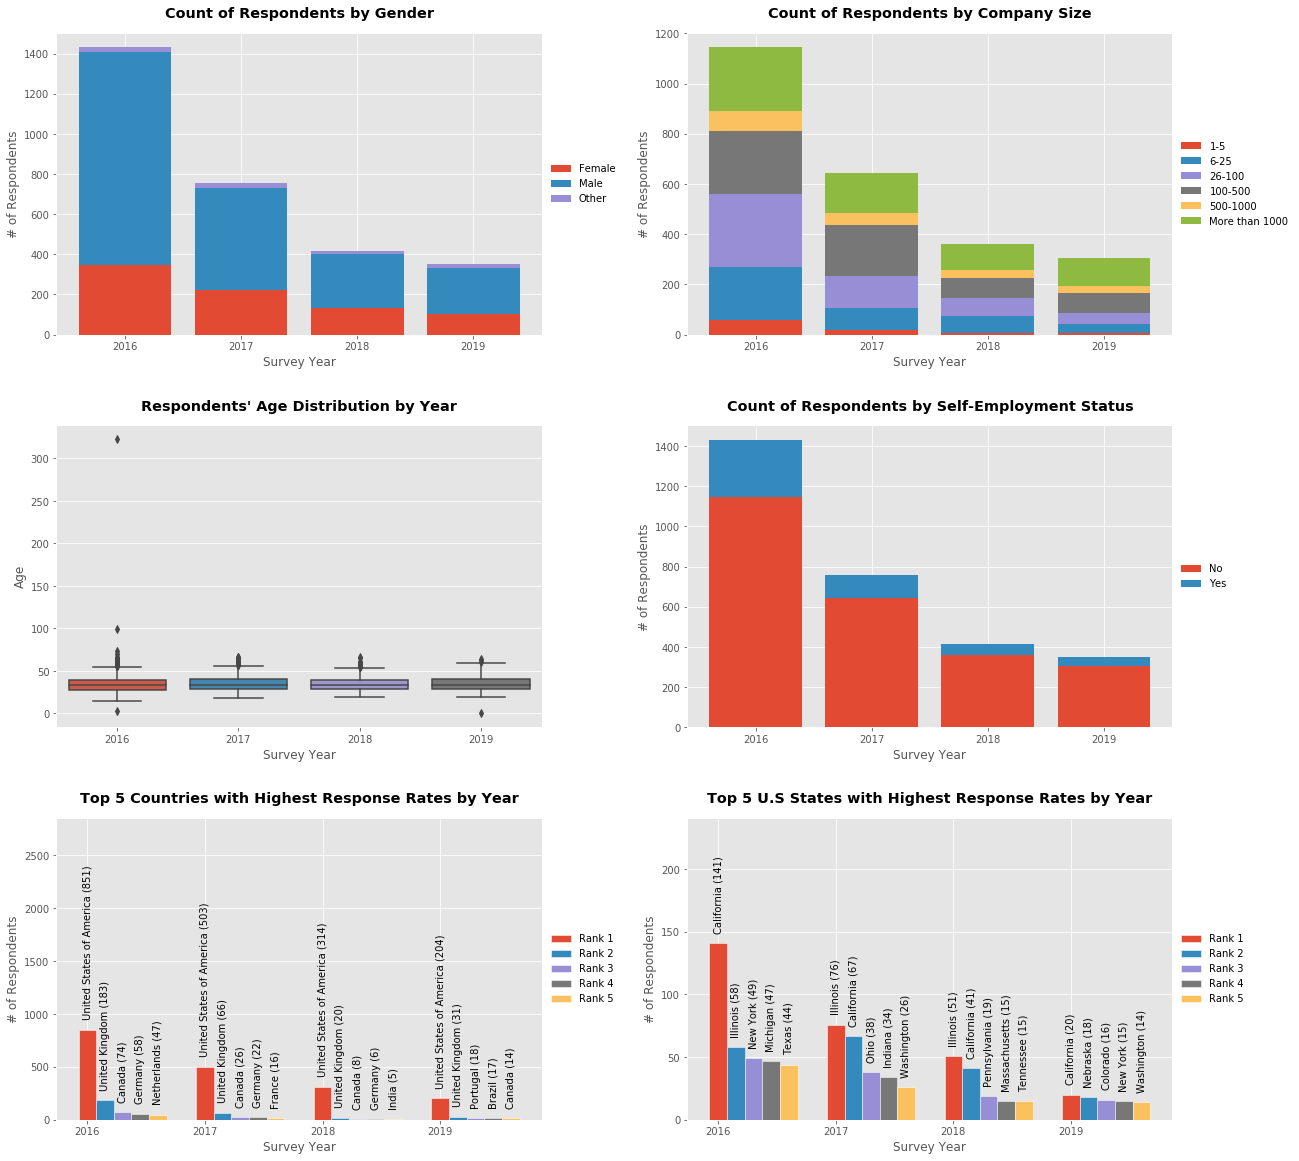

In [17]:
#initialize subplots
fig, ax = plt.subplots(3, 2, figsize = (20, 20))
#set plot style
plt.style.use("ggplot")
#control spacing between subplots
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)

#------------------------------------------------------------------------------------------------------------
#for gender plot
#------------------------------------------------------------------------------------------------------------

bottom_vals = np.zeros(len(osmi_years_lst))
for gend_ind, gend_cat in enumerate(resp_cnt_by_gender_yr["Gender"].unique()):

    #get the respondent count for the given gender category
    gend_resp_vals = resp_cnt_by_gender_yr[resp_cnt_by_gender_yr["Gender"] == gend_cat]["# of Respondents"].values
    #plot bar graph
    ax[0,0].bar(osmi_years_lst, gend_resp_vals, label = gend_cat, bottom = bottom_vals)
    bottom_vals += gend_resp_vals
    
#show legend    
ax[0,0].legend(loc = "center left", bbox_to_anchor = (1, 0.5), frameon = False)
#fix x-ticks to show year
ax[0,0].set_xticks(osmi_years_lst)
#set title and axis labels
ax[0,0].set_title("Count of Respondents by Gender", fontweight = "bold", y = 1.03)
ax[0,0].set(xlabel = "Survey Year", ylabel = "# of Respondents")

#------------------------------------------------------------------------------------------------------------
#for company size plot
#------------------------------------------------------------------------------------------------------------

bottom_vals = np.zeros(len(osmi_years_lst))
for size_ind, size_cat in enumerate(resp_cnt_by_size_yr["EplyeeNumber"].unique()):

    #get the respondent count for the given size category
    size_resp_vals = resp_cnt_by_size_yr[resp_cnt_by_size_yr["EplyeeNumber"] == size_cat]["# of Respondents"].values
    #plot bar graph
    ax[0,1].bar(osmi_years_lst, size_resp_vals, label = size_cat, bottom = bottom_vals)
    bottom_vals += size_resp_vals
    
#show legend    
ax[0,1].legend(loc = "center left", bbox_to_anchor = (1, 0.5), frameon = False)
#fix x-ticks to show year
ax[0,1].set_xticks(osmi_years_lst)
#set title and axis labels
ax[0,1].set_title("Count of Respondents by Company Size", fontweight = "bold", y = 1.03)
ax[0,1].set(xlabel = "Survey Year", ylabel = "# of Respondents")

#------------------------------------------------------------------------------------------------------------
#for age distribution plot
#------------------------------------------------------------------------------------------------------------

#plot a box plot for the age distribution
sns.catplot(x = "Year", \
            y = "Age", \
            data = final_osmi_df,\
            kind = "box", \
            ax = ax[1,0])

#set title and axis labes
ax[1,0].set_title("Respondents' Age Distribution by Year", fontweight = "bold", y = 1.03)
ax[1,0].set(xlabel = "Survey Year", ylabel = "Age")

plt.close()

#------------------------------------------------------------------------------------------------------------
#for self-employment plot
#------------------------------------------------------------------------------------------------------------

bottom_vals = np.zeros(len(osmi_years_lst)); 
for selfem_ind, selfem_cat in enumerate(resp_cnt_by_selfem_yr["Selfemploy"].unique()):

    #get the respondent count for the given self-employment category
    selfem_resp_vals = resp_cnt_by_selfem_yr[resp_cnt_by_selfem_yr["Selfemploy"] == selfem_cat]["# of Respondents"].values
    #plot bar graph
    ax[1,1].bar(osmi_years_lst, selfem_resp_vals, label = selfem_cat, bottom = bottom_vals)
    bottom_vals += selfem_resp_vals
    
#show legend    
ax[1,1].legend(loc = "center left", bbox_to_anchor = (1, 0.5), frameon = False)
#fix x-ticks to show year
ax[1,1].set_xticks(osmi_years_lst)
#set title and axis labels
ax[1,1].set_title("Count of Respondents by Self-Employment Status", fontweight = "bold", y = 1.03)
ax[1,1].set(xlabel = "Survey Year", ylabel = "# of Respondents")

#------------------------------------------------------------------------------------------------------------
#for top 5 ranking country work location plot
#------------------------------------------------------------------------------------------------------------

#subset to the top 5 countries with the highest number of responses in each year
rank_num = 5
#create ranking order 
resp_cnt_by_cntr_yr["RANK"] = resp_cnt_by_cntr_yr.groupby("Year").cumcount() + 1

#initial x-position for bars
xbar_pos = np.arange(len(osmi_years_lst))*2
#location of x-tick
ax[2,0].set_xticks(xbar_pos)
#rename x-tick labels
ax[2,0].set_xticklabels(osmi_years_lst)

for rank in range(1, rank_num+1):
    
    #get all the values associated with the given rank for each year
    resp_values_by_rank = resp_cnt_by_cntr_yr[resp_cnt_by_cntr_yr["RANK"] == rank]["# of Respondents"].values
    #plot bar plot
    cntr_bars = ax[2,0].bar(xbar_pos, resp_values_by_rank, width = 0.3, edgecolor = "white", label = "Rank " + str(rank))
    xbar_pos = [xpos + 0.3 for xpos in xbar_pos]
    
    #add labels to identify the countries in each bar
    cntr_labels = resp_cnt_by_cntr_yr[resp_cnt_by_cntr_yr["RANK"] == rank]["WorkCountries"].values
    for bar_ind, bar in enumerate(cntr_bars):
        bar_height = bar.get_height()
        ax[2,0].annotate("{}".format(cntr_labels[bar_ind] + " (" + str(bar_height) + ")"), \
                         xy = (bar.get_x() + bar.get_width()/2, bar_height), \
                         xytext = (0,10), \
                         textcoords = "offset points", \
                         ha = "center", \
                         va = "bottom", \
                         rotation = 90)
    
#show legend
ax[2,0].legend(loc = "center left", bbox_to_anchor = (1, 0.5), frameon = False)
#set title and axis labels
ax[2,0].set_title("Top 5 Countries with Highest Response Rates by Year", fontweight = "bold", y = 1.03)
ax[2,0].set(xlabel = "Survey Year", ylabel = "# of Respondents")
#change y limits
buffer_room_for_labels = 2000
max_ylim = resp_cnt_by_cntr_yr["# of Respondents"].max() + buffer_room_for_labels
ax[2,0].set_ylim(0, max_ylim)

#------------------------------------------------------------------------------------------------------------
#for top 5 ranking U.S state work location plot
#------------------------------------------------------------------------------------------------------------

#create ranking order 
resp_cnt_by_states_yr["RANK"] = resp_cnt_by_states_yr.groupby("Year").cumcount() + 1

#initial x-position for bars
xbar_pos = np.arange(len(osmi_years_lst))*2
#location of x-tick
ax[2,1].set_xticks(xbar_pos)
#rename x-tick labels
ax[2,1].set_xticklabels(osmi_years_lst)

for rank in range(1, rank_num+1):
    
    #get all the values associated with the given rank for each year
    resp_values_by_rank = resp_cnt_by_states_yr[resp_cnt_by_states_yr["RANK"] == rank]["# of Respondents"].values
    #plot bar plot
    states_bar = ax[2,1].bar(xbar_pos, resp_values_by_rank, width = 0.3, edgecolor = "white", label = "Rank " + str(rank))
    xbar_pos = [xpos + 0.3 for xpos in xbar_pos]
    
    #add labels to identify the states in each bar
    states_labels = resp_cnt_by_states_yr[resp_cnt_by_states_yr["RANK"] == rank]["WorkUSTerritories"].values
    for bar_ind, bar in enumerate(states_bar):
        bar_height = bar.get_height()
        ax[2,1].annotate("{}".format(states_labels[bar_ind] + " (" + str(bar_height) + ")"), \
                         xy = (bar.get_x() + bar.get_width()/2, bar_height), \
                         xytext = (0,10), \
                         textcoords = "offset points", \
                         ha = "center", \
                         va = "bottom", \
                         rotation = 90)

    
#show legend
ax[2,1].legend(loc = "center left", bbox_to_anchor = (1, 0.5), frameon = False)
#set title and axis labels
ax[2,1].set_title("Top 5 U.S States with Highest Response Rates by Year", fontweight = "bold", y = 1.03)
ax[2,1].set(xlabel = "Survey Year", ylabel = "# of Respondents")
#change y limits
buffer_room_for_labels = 100
max_ylim = resp_cnt_by_states_yr["# of Respondents"].max() + buffer_room_for_labels
ax[2,1].set_ylim(0, max_ylim)

plt.show();

<a id = freq_mh_provided></a>
## III. How frequently are mental health services provided to employees among technology companies?

[Back to Project Overview](#project_overview)

The goal of this section is to evaluate how frequently respondents are being provided access to mental health resources in the form of employer-sponsored health insurance and whether having such insurance in place can help boost discussion about mental health topics in the workplace.

---

a) Plot bar plot of respondent counts by:

- Whether employer provide mental health benefits
- Whether employer has discussed mental health issues

**KEY TAKEAWAYS:**

It is suprising to see in the second plot that the red bar is significantly higher than the "No" (blue), "Not eligible for coverage" (purple), and "I don't know" (grey) bars in both the "Yes" and "No" x-axis categories. We would expect that providing employer-sponsored health coverage for mental health benefits would lead to increased employer discussion of mental health. However, the fact that we see a high red bar for both the "Yes" and "No" x-axis categories suggests that access to mental health insurance coverage may not necessarily lead to increased employer discussion of mental health. In other words, access to health insurance coverage for mental health may be a necessary, but not sufficient condition.

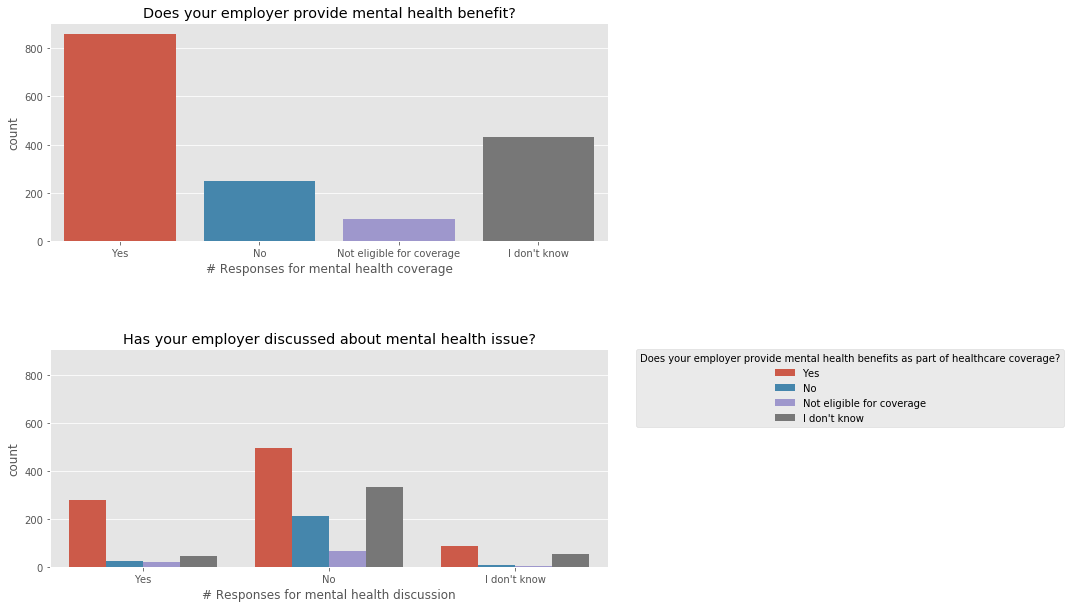

In [18]:
#drop the null value 
final_osmi_nna=final_osmi_df[final_osmi_df['EplyrTechOrNot'].notnull()]

#make sure the answer is either yes or no to this question
final_osmi_nna['EplyrTechOrNot'] = final_osmi_nna['EplyrTechOrNot'].replace([1,True], 'Yes')
final_osmi_nna['EplyrTechOrNot'] = final_osmi_nna['EplyrTechOrNot'].replace([0,False], 'No')

#dropping the null value
dis_list = ["PreEplyrFormalDiscussed", "EplyrFormalDiscussed"]
dis_data=final_osmi_nna[final_osmi_nna[dis_list[0]].notnull()&final_osmi_nna[dis_list[1]].notnull()&(final_osmi_nna['EplyrTechOrNot']=='Yes')]


#change the answer to yes, no, not eligible for coverage
dis_data[dis_list[0]]=dis_data[dis_list[0]].replace(['Yes, they all did','Some did'],'Yes')
dis_data[dis_list[0]]=dis_data[dis_list[0]].replace(['None did',],'No')
dis_data['EplyrProvideBenefitsInCoverage']=dis_data['EplyrProvideBenefitsInCoverage'].\
replace(['Not eligible for coverage / N/A','Not eligible for coverage / NA'],'Not eligible for coverage')

#count
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True,figsize=(10,10))
f1=sns.countplot(data=dis_data,x='EplyrProvideBenefitsInCoverage',ax=ax1,order=['Yes','No','Not eligible for coverage',"I don't know"])
f2=sns.countplot(data=dis_data,x=dis_list[1],order=['Yes','No',"I don't know"],hue='EplyrProvideBenefitsInCoverage',ax=ax2,hue_order=['Yes','No','Not eligible for coverage',"I don't know"])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Does your employer provide mental health benefits as part of healthcare coverage?')
plt.subplots_adjust(hspace=0.5)
f1.set_title('Does your employer provide mental health benefit?')
f2.set_title('Has your employer discussed about mental health issue?')
f1.set_xlabel('# Responses for mental health coverage')
f2.set_xlabel('# Responses for mental health discussion')

plt.show();

b) Plot bar plot regarding respondents' comfortability to discuss mental health issues with co-workers and surpervisors:

**KEY TAKEWAYS:**

In the below plot, we tried to explore whether providing mental health benefits encourages employees to discuss mental health issue with coworkers or supervisors. As we can see, people are less willing to discuss mental health issue when there is no healthcare coverage. Thus, while part A of this question suggests that health insurance benefits may not lead to more formal discussion of mental health by the larger employing entity, it does have an impact on generating more informal discussions or comfortability in discussing with co-workers and supervisors.


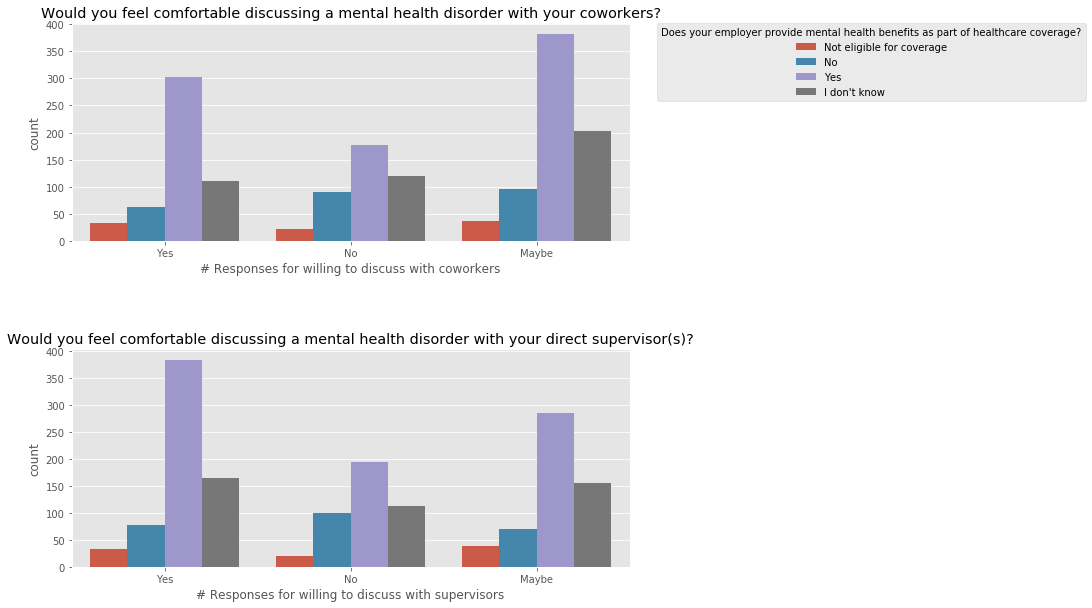

In [19]:
col_list = ['ComfortDiscussWCoworkers', 'ComfortDiscussWSupervisor']

#plot the observation
fig2, (ax1, ax2) = plt.subplots(nrows=2, sharey=True,figsize=(10,10))
g1=sns.countplot(data=dis_data,x=col_list[0],ax=ax1,order=['Yes','No','Maybe'],hue='EplyrProvideBenefitsInCoverage')
g2=sns.countplot(data=dis_data,x=col_list[1],ax=ax2,order=['Yes','No','Maybe'],hue='EplyrProvideBenefitsInCoverage')
plt.legend(bbox_to_anchor=(1.05, 2.5), loc=2, borderaxespad=0., title='Does your employer provide mental health benefits as part of healthcare coverage?')
plt.subplots_adjust(hspace=0.5,wspace=1)
g1.legend_.remove()
g1.set_title('Would you feel comfortable discussing a mental health disorder with your coworkers?')
g2.set_title('Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?')
g1.set_xlabel('# Responses for willing to discuss with coworkers')
g2.set_xlabel('# Responses for willing to discuss with supervisors')
plt.show()

<a id = "impact_mh"></a>
## IV. What is the impact of untreated mental health issues on employees' work productivity?

[Back to Project Overview](#project_overview)

This section focuses on measuring the impact that mental health issues can have on worker productivity to get a better sense of what employers may be losing in not helping employees receive treatment for mental health issues.

---

a) Graph plots indicating the prevalence level of mental health illnesses and the impact such illnesses have on employees' productivity at work. 

**KEY TAKEAWAYS:**

The graphs show that more than 40% of respondents indicated having some form of mental illness. For respondents whose mental health is not being treated effectively, more than 40% of them say that it "often" interferes with their work productivity in comparison to the 5% when mental health is effectively being treated. Thus, employers have much to gain in terms of worker productivity and consequently profits if they take greater steps to discussing mental health issues formally within their organizations and helping employees access adequate treatments.

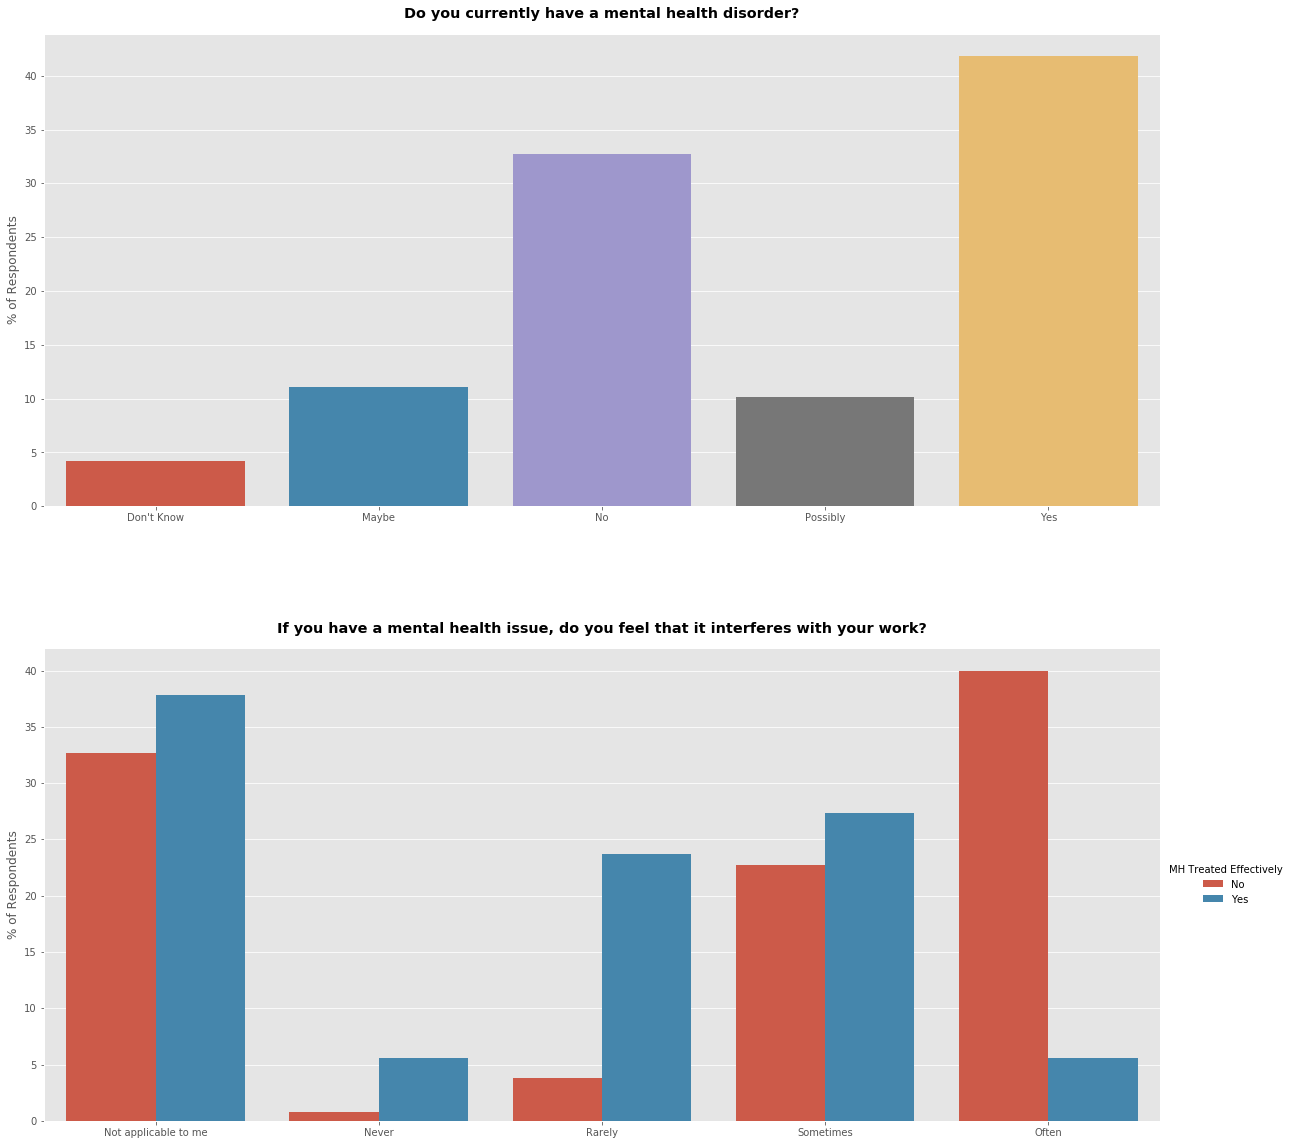

In [20]:
plt.style.use("ggplot")

#calculate the number of people that currently have mental illness
resp_w_mh = final_osmi_df.groupby(['CurrentStatusMHD'])["RESPONSE_ID"].count().reset_index()
resp_w_mh = resp_w_mh.rename(columns = {"RESPONSE_ID": "# of Respondents"})
resp_w_mh["% of Respondents"] = 100*resp_w_mh["# of Respondents"]/resp_w_mh["# of Respondents"].sum()

#------------------------------------------------------------------------------------------------------------

#calculate the number of people whose employer discussed mental health issue
employer_discuss_mh = final_osmi_df.groupby(["EplyrFormalDiscussed"])["RESPONSE_ID"].count().reset_index()
employer_discuss_mh = employer_discuss_mh.rename(columns = {"RESPONSE_ID": "# of Respondents"})
employer_discuss_mh["% of Respondents"] = 100*employer_discuss_mh["# of Respondents"]/employer_discuss_mh["# of Respondents"].sum()

#------------------------------------------------------------------------------------------------------------

#calculate the numer of people who believe mental illness interfere with their work when not being treated effectively
interfere_nottreat_df = final_osmi_df.groupby(['InterfereWorkWhenTreatedEffectivelyNo'])["RESPONSE_ID"].count().reset_index()
interfere_nottreat_df = interfere_nottreat_df.rename(columns = {"RESPONSE_ID": "# of Respondents",
                                                                "InterfereWorkWhenTreatedEffectivelyNo": "InterfereWork"})
interfere_nottreat_df["% of Respondents"] = 100 * interfere_nottreat_df["# of Respondents"]/interfere_nottreat_df["# of Respondents"].sum()
interfere_nottreat_df["Treated Effectively"] = "No"

#calculate the numer of people who believe mental illness interfere with their work whenbeing treated effectively
interfere_treat_df = final_osmi_df.groupby(['InterfereWorkWhenTreatedEffectivelyYes'])["RESPONSE_ID"].count().reset_index()
interfere_treat_df = interfere_treat_df.rename(columns = {"RESPONSE_ID": "# of Respondents",
                                                         "InterfereWorkWhenTreatedEffectivelyYes": "InterfereWork"})
interfere_treat_df["% of Respondents"] = 100 * interfere_treat_df["# of Respondents"]/interfere_treat_df["# of Respondents"].sum()
interfere_treat_df["Treated Effectively"] = "Yes"

#combine results from interfere with work when treated effectively and when not treated effectively
interfere_comb_df = pd.concat([interfere_nottreat_df, interfere_treat_df])

#------------------------------------------------------------------------------------------------------------

#graph results
fig, ax = plt.subplots(2, 1, figsize = (20, 20))
fig.subplots_adjust(hspace = 0.3)

sns.catplot(x = 'CurrentStatusMHD', \
            y = "% of Respondents", \
            data = resp_w_mh, \
            kind = "bar", \
            ax = fig.axes[0])
fig.axes[0].set_title('Do you currently have a mental health disorder?', \
                      y = 1.02, \
                      fontweight = "bold")
fig.axes[0].set_xlabel("")

plt.close();

sns.catplot(x = "InterfereWork",\
            y = "% of Respondents", \
            data = interfere_comb_df, \
            hue = "Treated Effectively", \
            kind = "bar",
            ax = fig.axes[1],
            order = ["Not applicable to me", "Never", "Rarely", "Sometimes", "Often"])
fig.axes[1].set_title('If you have a mental health issue, do you feel that it interferes with your work?',\
                     y = 1.02,\
                     fontweight = "bold")
fig.axes[1].set_xlabel("")

fig.axes[1].legend(loc = "center left", 
                   bbox_to_anchor = (1, 0.5),
                   frameon = False, 
                   title = "MH Treated Effectively")
plt.close();

<a id = "diff_phys_ment_disc"></a>
## V. Is there a difference between respondents' willingness to discuss mental versus physical health?

[Back to Project Overview](#project_overview)

Traditionally, individuals have been more open to discussing physical health issues with their employers. This section focuses on evaluating how large the discrepancy is between discussion of physical health and mental health, so that employers may begin to take steps to close this gap.

---

a) Plot a graph showing the difference between respondents' willingness to disclose physical versus mental health issues during employee interviews.

**KEY TAKEAWAYS:**

The bar plots indicate that respondents show a significantly higher willingness to discuss physical health issues rather than mental health issues. Roughly 25% of respondents stated "Yes" for willingness to discuss physical health issues in comparison to the meager ~5% for willingness to discuss mental health.

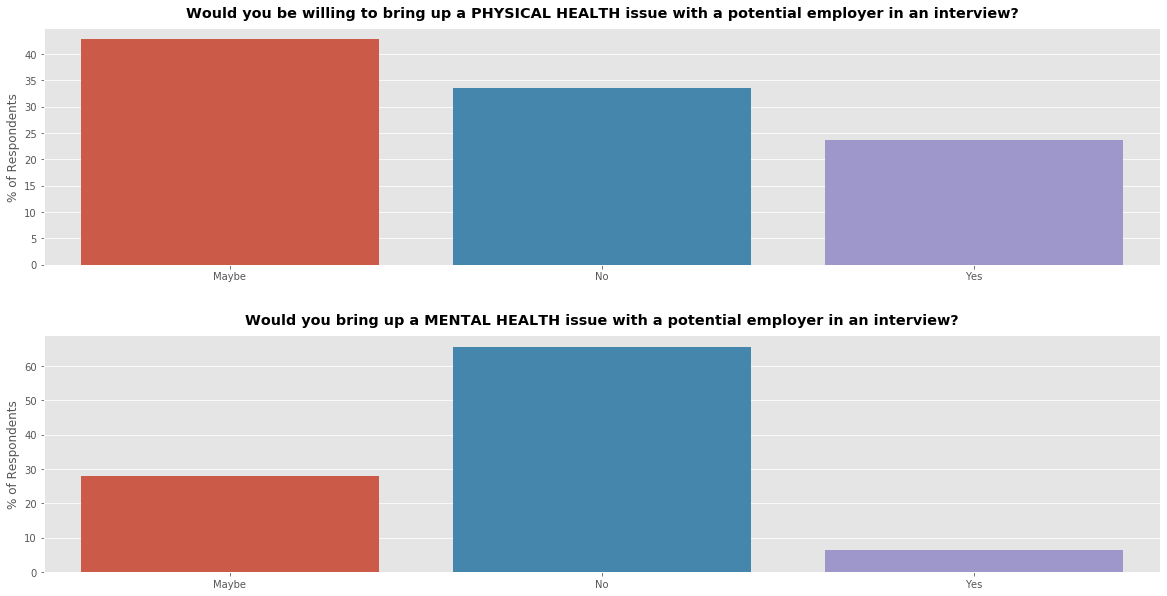

In [21]:
#calculate the number of people willing to discuss physical health
physical_will_df = final_osmi_df.groupby(["InterviewReleasePhysicalWillingness"])["RESPONSE_ID"].count().reset_index()
physical_will_df = physical_will_df.rename(columns = {"RESPONSE_ID": "# of Respondents"})
physical_will_df["% of Respondents"] = 100*physical_will_df["# of Respondents"]/physical_will_df["# of Respondents"].sum()
#calculate the number of people willing to discuss mental health
mental_will_df = final_osmi_df.groupby("InterviewReleaseMentalWillingness")["RESPONSE_ID"].count().reset_index()
mental_will_df = mental_will_df.rename(columns = {"RESPONSE_ID": "# of Respondents"})
mental_will_df["% of Respondents"] = 100*mental_will_df["# of Respondents"]/mental_will_df["# of Respondents"].sum()


#plot results
fig, ax = plt.subplots(2,1, figsize = (20, 10))
fig.subplots_adjust(hspace = 0.3)

sns.barplot(x = "InterviewReleasePhysicalWillingness", 
            y = "% of Respondents", 
            data = physical_will_df, ax = ax[0]);
ax[0].set_title("Would you be willing to bring up a PHYSICAL HEALTH issue with a potential employer in an interview?",\
               y = 1.02,\
               fontweight = "bold")
ax[0].set_xlabel("")

sns.barplot(x = "InterviewReleaseMentalWillingness", y = "% of Respondents", data = mental_will_df, ax = ax[1]);
ax[1].set_title("Would you bring up a MENTAL HEALTH issue with a potential employer in an interview?",\
               y = 1.02, \
               fontweight = "bold")
ax[1].set_xlabel("")

plt.show();

<a id = "corr_mh_loc"></a>
## VI. Is there a correlation between mental health and location in which employees work, either by country or U.S states?

[Back to Project Overview](#project_overview)

U.S states and countries have differing policies when it comes to health insurance coverage for mental health benefits as well as political and religious leanings that may affect willingness to discuss mental health issues. This section focuses on evaluating whether the impact of these factors can be seen in the survey data.

---

a) Graph pie plots comparing current mental health status between U.S and non-U.S countries where respondents work.

**KEY TAKEWAYS:**

From the pie charts, it looks like the respondents from US are more likely to have mental health disorder at the time of the survey. But this result might be biased as confounding factors may exist, such as people from US being more likely to reveal mental health issue than those from other countries, or they might be more open to addressing the issue when taking the survey. In order to consolidate our founding here, we will compare the willingness of sharing mental health issue between US people and Non-US people. And, the accessibility to resources that might help people to confirm their mental health status also can affect the result of our founding, so we would look into it later.

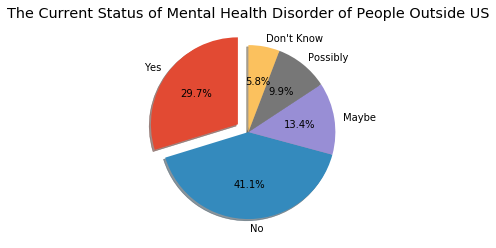

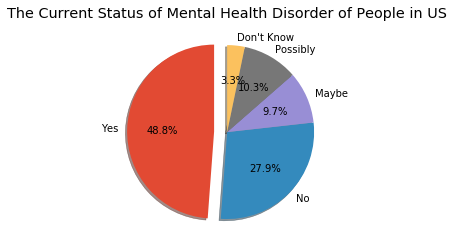

In [22]:
# Select the columns that are somewhat related to my focus to form a sub dataframe
myfocus = final_osmi_df[['CurrentStatusMHD', 
                         'FamilyHistory', 
                         'ResourceAwareness', 
                         'PastHistoryMHD', 
                         'ShareFFWillingness', 
                         'RoleITOrNot', 
                         'LiveUSTerritories', 
                         'WorkUSTerritories', 
                         'LiveCountries', 
                         'WorkCountries', 
                         'Age', 
                         'Gender', 
                         'Year']]

# Plot & compare Non-US and US CurrentStatusMHD

# Filter the Non-US data from the origin column: us
non_us = myfocus[myfocus["WorkCountries"] != "United States of America"]

# 1. Labels for every catagory in CurrentStatusMHD
labels = "Yes", "No", "Maybe", "Possibly", "Don't Know"
# 2. Get counts of every catagory in CurrentStatusMHD, store them in list called "sizes"

Wa0 = non_us['CurrentStatusMHD'].count()
Wa1 = non_us[non_us['CurrentStatusMHD'] == "Yes"]['CurrentStatusMHD'].count()
Wa2 = non_us[non_us['CurrentStatusMHD'] == "No"]['CurrentStatusMHD'].count()
Wa3 = non_us[non_us['CurrentStatusMHD'] == "Maybe"]['CurrentStatusMHD'].count()
Wa4 = non_us[non_us['CurrentStatusMHD'] == "Possibly"]['CurrentStatusMHD'].count()
Wa5 = non_us[non_us['CurrentStatusMHD'] == "Don't Know"]['CurrentStatusMHD'].count()

sizesWa = [Wa1, Wa2, Wa3, Wa4, Wa5]

# Filter the US data from the origin column: us
us = myfocus[myfocus["WorkCountries"] == "United States of America"]

Ua0 = us['CurrentStatusMHD'].count()
Ua1 = us[us['CurrentStatusMHD'] == "Yes"]['CurrentStatusMHD'].count()
Ua2 = us[us['CurrentStatusMHD'] == "No"]['CurrentStatusMHD'].count()
Ua3 = us[us['CurrentStatusMHD'] == "Maybe"]['CurrentStatusMHD'].count()
Ua4 = us[us['CurrentStatusMHD'] == "Possibly"]['CurrentStatusMHD'].count()
Ua5 = us[us['CurrentStatusMHD'] == "Don't Know"]['CurrentStatusMHD'].count()

sizesUa = [Ua1, Ua2, Ua3, Ua4, Ua5]

# 3. Set the catagory of "Yes" that I want to slice from the pie. 
explode = (0.15, 0, 0, 0 ,0)

# 4. Plot settings
fig1, axs1 = plt.subplots()

axs1.pie(sizesWa, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("The Current Status of Mental Health Disorder of People Outside US")


fig2, axs2 = plt.subplots()
axs2.pie(sizesUa, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("The Current Status of Mental Health Disorder of People in US")

plt.show();

b) Graph pie plots comparing willingness to discuss mental health between U.S and non-U.S countries where respondents work.

**KEY TAKEAWAYS:**

We could now see the US and Non-US people's willingnesses on sharing mental health issue with family and friends are nearly at the same level ("Very open" + "Somewhat open" + "Neutral", Non-US = 70.8%, US = 72.8%, it does not show huge statistical difference). Although this variable just measure the willingness on sharing with family and friends, we could still get partial insights of the general attitudes of sharing mental health issue with others, after all, the surveys were anonymous. Now we could support our previous founding more.

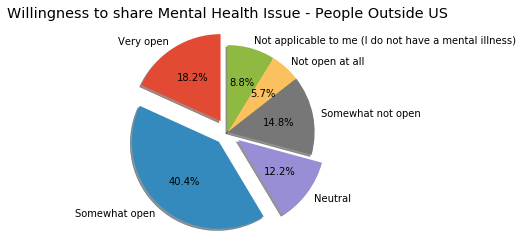

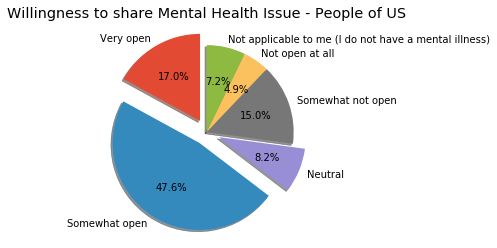

In [23]:
# Plot Pie charts for these viaribles. 
# 1. Labels for every catagory in ShareFFWillingness
labelsb = "Very open", "Somewhat open", "Neutral", "Somewhat not open", "Not open at all", "Not applicable to me (I do not have a mental illness)"
# 2. Get counts of every catagory in ShareFFWillingness, store them in list called "sizes"

Wb1 = non_us[non_us['ShareFFWillingness'] == "Very open"]['ShareFFWillingness'].count()
Wb2 = non_us[non_us['ShareFFWillingness'] == "Somewhat open"]['ShareFFWillingness'].count()
Wb3 = non_us[non_us['ShareFFWillingness'] == "Neutral"]['ShareFFWillingness'].count()
Wb4 = non_us[non_us['ShareFFWillingness'] == "Somewhat not open"]['ShareFFWillingness'].count()
Wb5 = non_us[non_us['ShareFFWillingness'] == "Not open at all"]['ShareFFWillingness'].count()
Wb6 = non_us[non_us['ShareFFWillingness'] == "Not applicable to me (I do not have a mental illness)"]['ShareFFWillingness'].count()

sizesWb = [Wb1, Wb2, Wb3, Wb4, Wb5, Wb6]

Ub1 = us[us['ShareFFWillingness'] == "Very open"]['ShareFFWillingness'].count()
Ub2 = us[us['ShareFFWillingness'] == "Somewhat open"]['ShareFFWillingness'].count()
Ub3 = us[us['ShareFFWillingness'] == "Neutral"]['ShareFFWillingness'].count()
Ub4 = us[us['ShareFFWillingness'] == "Somewhat not open"]['ShareFFWillingness'].count()
Ub5 = us[us['ShareFFWillingness'] == "Not open at all"]['ShareFFWillingness'].count()
Ub6 = us[us['ShareFFWillingness'] == "Not applicable to me (I do not have a mental illness)"]['ShareFFWillingness'].count()

sizesUb = [Ub1, Ub2, Ub3, Ub4, Ub5, Ub6]

# 3. Set the catagory of "Very open" & "Somewhat open" that I want to slice from the pie. 
explode = (0.15, 0.15, 0.15, 0, 0 ,0)

# 4. Plot settings
fig1, axs1 = plt.subplots()

axs1.pie(sizesWb, explode=explode, labels=labelsb, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Willingness to share Mental Health Issue - People Outside US")


fig2, axs2 = plt.subplots()
axs2.pie(sizesUb, explode=explode, labels=labelsb, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Willingness to share Mental Health Issue - People of US")


plt.show()

c) Graph pie plots comparing current mental health status between U.S and non-U.S countries where respondents live.

**KEY TAKEWAYS:**

Interesting trend found here. Those people of US who live and work in different states are with a moderate higher rate of MHD (53.0% > 48.8%). Perhaps the different states here refer to remote working. It is possible that people who work remotely are lack of resources to confirm MHD and are less likely to share mental health status with others in the companies.

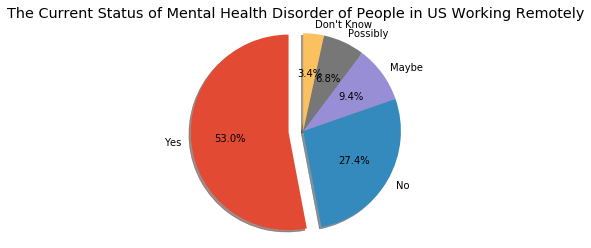

In [24]:
# Plot USRemote CurrentStatusMHD
usRemote = us[us["LiveUSTerritories"] != us["WorkUSTerritories"]]

# 1. Labels for every catagory in CurrentStatusMHD
labels = "Yes", "No", "Maybe", "Possibly", "Don't Know"

# 2. Get counts of every catagory in CurrentStatusMHD, store them in list called "sizes"
UaRemote0 = usRemote['CurrentStatusMHD'].count()
UaRemote1 = usRemote[usRemote['CurrentStatusMHD'] == "Yes"]['CurrentStatusMHD'].count()
UaRemote2 = usRemote[usRemote['CurrentStatusMHD'] == "No"]['CurrentStatusMHD'].count()
UaRemote3 = usRemote[usRemote['CurrentStatusMHD'] == "Maybe"]['CurrentStatusMHD'].count()
UaRemote4 = usRemote[usRemote['CurrentStatusMHD'] == "Possibly"]['CurrentStatusMHD'].count()
UaRemote5 = usRemote[usRemote['CurrentStatusMHD'] == "Don't Know"]['CurrentStatusMHD'].count()

sizesUaRemote = [UaRemote1, UaRemote2, UaRemote3, UaRemote4, UaRemote5]

# 3. Set the catagory of "Yes" that I want to slice from the pie. 
explode = (0.15, 0, 0, 0 ,0)

# 4. Plot settings
fig3, ax3 = plt.subplots()
ax3.pie(sizesUaRemote, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax3.axis('equal')
plt.title("The Current Status of Mental Health Disorder of People in US Working Remotely")
plt.show()

d) Graph rate of mental health disorder for states with more than 10 Cases:

**KEY TAKEWAYS:**

From the Current Mental Health Disorder rate plot (we plot the states with more that 10 cases), we could observe that the respondents from PA are with the highest rate of MDH, while respondents from Nebraska are with the lowest rate of MDH. We have not gotten rid off the confounding factors like the resources in confirming MDH status or willingness in sharing MDH statues. So the obseravation might be biased.

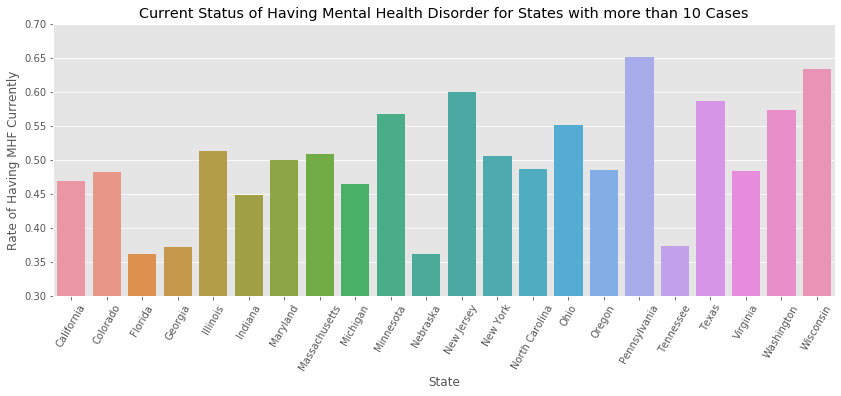

In [25]:
# Refine the us DataFrame for Territories and MHD Status research
us_refine = us[["WorkUSTerritories", "CurrentStatusMHD"]]

#create binary dummy variable (yes = 1)
mhd_cnt = pd.DataFrame(us_refine.groupby(["WorkUSTerritories", "CurrentStatusMHD"])["CurrentStatusMHD"].count())

#calculate the number of “yes” for each US state
mhd_cnt = mhd_cnt.rename(columns = {"CurrentStatusMHD": "count"}).reset_index()

#calculate the % of yes for each state
mhd_cnt["perc_yes_mhd"] = mhd_cnt["count"]/mhd_cnt.groupby("WorkUSTerritories")["count"].transform("sum")

#Sort data with conditions that only respond "Yes" for CurrentStatusMHD and only states with more than 10 respondent, store in yes_mhd_cnt
yes_mhd_cnt = mhd_cnt[(mhd_cnt["CurrentStatusMHD"] == "Yes") & (mhd_cnt["count"] > 10)]

# Plot the Current Status of Having Mental Health Disorder for States with more than 10 Respondents
plt.figure(figsize=(14, 5))
sns.barplot(data=yes_mhd_cnt, x="WorkUSTerritories", y="perc_yes_mhd")
plt.xticks(rotation=60)
plt.xlabel("State")
plt.ylabel("Rate of Having MHF Currently")
plt.ylim(.3, .7)
plt.title("Current Status of Having Mental Health Disorder for States with more than 10 Cases")

plt.show()

e) Geographic plot of current mental health status by U.S states:

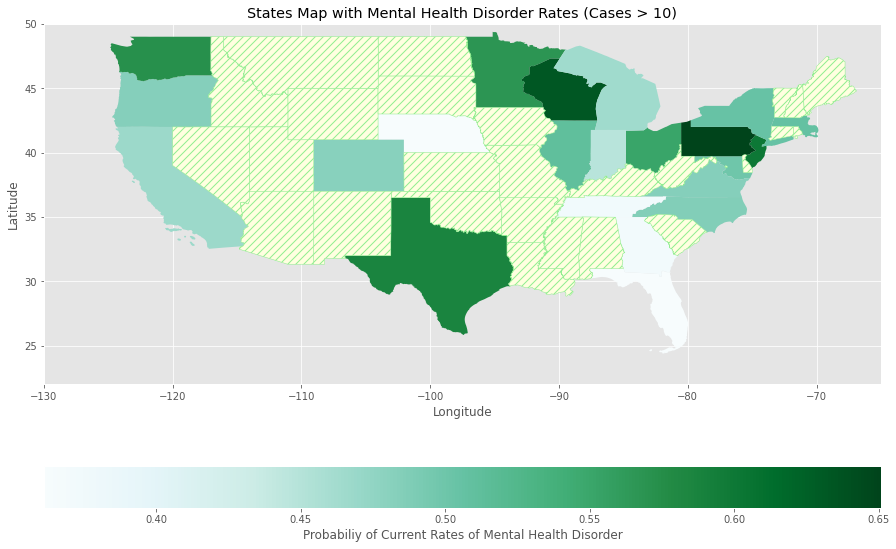

In [40]:
# Get the map information from .shp file (downloaded from data.gov zip file and put in our Shared drive) and store it in dataframe called usa
# The sharable link for this file is: https://drive.google.com/open?id=1Yamj8JHmvVYJZjI2rZUfES08T5NnS3pc
# The orginal link for the zip file: https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip
usa = gpd.read_file("/content/drive/Shared drives/IS833 Team 2 OSMI-Project/tl_2019_us_state/tl_2019_us_state.shp")

# Merge the yes_mhd_cnt DataFrame with basic US map DataFrame
map_test0 = pd.merge(usa, yes_mhd_cnt, left_on="NAME", right_on="WorkUSTerritories", how='outer')

# Plot the top states in map, with Legend to show probability of Current MHD status of each state

map_test0.plot(column="perc_yes_mhd", 
               legend=True, legend_kwds={'label': "Probabiliy of Current Rates of Mental Health Disorder", 'orientation': "horizontal"}, 
               cmap='BuGn', 
               missing_kwds={'color': 'lightyellow', "edgecolor": "lightgreen", "hatch": "///"}, 
               figsize=(15, 10), 
               markersize=1.0, 
               )
plt.title("States Map with Mental Health Disorder Rates (Cases > 10)")
plt.xlim(-130, -65)
plt.ylim(22, 50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show();

<a id = "kmodes_clust"></a>
## VII: Feature Selection Using K-Modes Clustering

[Back to Project Overview](#project_overview)

The goal of this section is to use k-modes clustering to perform feature selection. Because our initial datasets contain a significant number of features, it would be too cumbersome to evaluate the pairwise relationship between all the features to identify key trends. By using k-modes clustering, we hope to filter the full list of features to those where our respondents show a high amount of variability or differences. Understanding the key features where our respondents differ the most will allow us to narrow the scope of our exploratory analysis and avoid including unnecessary or redundant features that do not offer a lot of additional information into our models.

---

a) Create a elbow plot to visually determine the optimal number of clusters to create. The elbow plot shows the within-cluster variance for each cluster number. We will select the "elbow point" (i.e. the point where the decrease in variance from increasing the number of cluster is less than the decrease in variance achieved at the current cluster number) to be our optimal cluster size. Based on the graph below, we have determine 3 to be out optimal number of clusters.

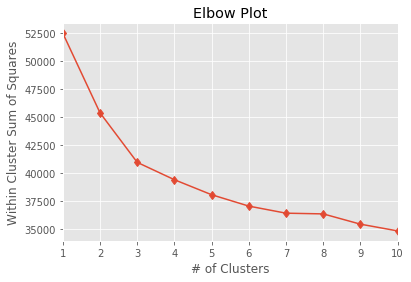

In [26]:
columns_lst = ["Selfemploy", \
                "PreEplyrFormalDiscussed", \
                "PreEplyrProvidedResourceToLearn", \
                "ProductivityAffected",\
                "CurrentStatusMHD",\
                "FamilyHistory",\
                "HavePreEplyr",\
                "ResourceAwareness",\
                "EplyrCoverageOptionsAwareness",\
                "EplyrProvideResourceToLearn",\
                "EplyrProvideBenefitsInCoverage",\
                "EplyrFormalDiscussed",\
                "HistorySeekTreatMHPro",\
                "PastHistoryMHD",\
                "UnsupportiveObs&Exp",\
                "ObsLedUnwillingness",\
                "PreEplyrProvidedBenefits",\
                "EplyeeNumber",\
                "AskLeaveFromWork",\
                "AffectedWorkTime",\
                "InterfereWorkWhenTreatedEffectivelyNo",\
                "InterfereWorkWhenTreatedEffectivelyYes",\
                "RevealToClientsContacts",\
                "RevealToCoworkersEplyees",\
                "AnonymityProtectedEplyr",\
                "EplyrTechOrNot",\
                "RoleITOrNot",\
                "AnonymityProtectedPreEplyr",\
                "PreEplyrOptionsAwareness",\
                "Gender",\
                "InterviewReleasePhysicalWillingness",\
                "InterviewReleaseMentalWillingness",\
                "ComfortDiscussWCoworkers",\
                "ComfortDiscussWSupervisor",\
                "BeWillingDiscussWSupervisor"
              ]

#clean variable name
osmi_df_for_km = final_osmi_df[columns_lst + ["Age"]]
osmi_df_for_km[columns_lst] = osmi_df_for_km[columns_lst].fillna("None")
osmi_df_for_km["Age"] = osmi_df_for_km["Age"].fillna(0)
osmi_df_for_km["EplyrTechOrNot"] = osmi_df_for_km["EplyrTechOrNot"].replace(1, "1")
osmi_df_for_km["EplyrTechOrNot"] = osmi_df_for_km["EplyrTechOrNot"].replace(0, "0")
osmi_df_for_km["RoleITOrNot"] = osmi_df_for_km["RoleITOrNot"].replace(1, "1")
osmi_df_for_km["RoleITOrNot"] = osmi_df_for_km["RoleITOrNot"].replace(0, "0")

#total number of cluster to test
tot_clust = 11
clust_result_df = pd.DataFrame(columns = ["cluster_num", "cluster_cost"])
for k_num in range(1, tot_clust):

    #initialize k-mode clustering
    #init =  Huang, Cao, random clustering method
    #n_init = Number of time the k-modes algorithm will be run with different
    #centroid seeds. The final results will be the best output of n_init consecutive runs in terms of c
    km = KModes(n_clusters = k_num, 
                init='random',
                n_init=10, 
                verbose=0)

    clusters = km.fit_predict(osmi_df_for_km, \
                              categorical = [i for i in range(len(osmi_df_for_km.columns)-1)] #tell the function the column index of the categorical columns
                             )

    #get the cost
    clust_cost = km.cost_
    
    inter_df = pd.DataFrame({"cluster_num": k_num, 
                             "cluster_cost": [clust_cost]})
    clust_result_df = pd.concat([clust_result_df, inter_df], ignore_index = True)

#create elbow plot to identify which cluster number is optimal
clust_result_df.plot(x = "cluster_num", y = "cluster_cost", marker = "d", title = "Elbow Plot");
plt.xlabel("# of Clusters")
plt.ylabel("Within Cluster Sum of Squares")
plt.legend().remove()
plt.show();

b) Using the optimal number of clusters determined in the prior step, re-run our k-modes clustering and evaluate the features associated each cluster's centroid. By looking at the features where the clusters differ from one another, we can subset our full list of features to those where our respondents show a high amount of variability.

In [32]:
#re-run kmodes clustering using the optimal cluster number
km = KModes(n_clusters = 3,
            init='random',
            n_init=10, 
            verbose=0)

clusters = km.fit_predict(osmi_df_for_km, \
                          categorical = [i for i in range(len(osmi_df_for_km.columns)-1)] #tell the function the column index of the categorical columns
                         )

#get the characteristics associated with the cluster centroids
centroids = km.cluster_centroids_

centroid_result_df = pd.DataFrame()
for centr_ind, centr in enumerate(centroids):
    
    inter_df = pd.DataFrame(centroids[centr_ind], columns = ["cluster" + str(centr_ind + 1)])
    centroid_result_df = pd.concat([centroid_result_df, inter_df], ignore_index = True, axis = 1)

centroid_result_df.columns = ["cluster" + str(i) for i in range(1, len(centroids) + 1)]
centroid_result_df["variable"] = columns_lst + ["Age"]

#get dataframe showing the features associated with each cluster centroid
centroid_result_df["same_val_flag"] = np.where((centroid_result_df["cluster1"] == centroid_result_df["cluster2"]) &\
                                               (centroid_result_df["cluster2"] == centroid_result_df["cluster3"]), \
                                               1, 0)
centroid_subdf = centroid_result_df[centroid_result_df["same_val_flag"] == 0]
variable_lst = list(centroid_subdf["variable"].values)
centroid_transpose = centroid_subdf[["cluster1", "cluster2", "cluster3"]].T
centroid_transpose.columns = variable_lst

centroid_transpose

,Selfemploy,ProductivityAffected,CurrentStatusMHD,FamilyHistory,ResourceAwareness,EplyrCoverageOptionsAwareness,EplyrProvideResourceToLearn,EplyrProvideBenefitsInCoverage,EplyrFormalDiscussed,HistorySeekTreatMHPro,PastHistoryMHD,ObsLedUnwillingness,PreEplyrProvidedBenefits,EplyeeNumber,AskLeaveFromWork,AffectedWorkTime,InterfereWorkWhenTreatedEffectivelyNo,InterfereWorkWhenTreatedEffectivelyYes,RevealToClientsContacts,RevealToCoworkersEplyees,AnonymityProtectedEplyr,EplyrTechOrNot,RoleITOrNot,PreEplyrOptionsAwareness,ComfortDiscussWCoworkers,ComfortDiscussWSupervisor,BeWillingDiscussWSupervisor,Age
cluster1,1,Yes,Yes,Yes,I know some,None,None,None,None,1,Yes,None,"No, none did",None,None,1-25%,Often,Not applicable to me,Not applicable to me,Not applicable to me,None,None,None,N/A (not currently aware),None,None,Some of my previous employers,31.0
cluster2,0,None,Yes,Yes,None,Yes,No,Yes,No,1,Yes,No,Some did,More than 1000,Somewhat easy,None,Often,Sometimes,None,None,I don't know,1,1,I was aware of some,Maybe,Yes,Some of my previous supervisors,30.0
cluster3,0,None,No,No,None,No,No,I don't know,No,0,No,None,I don't know,26-100,Somewhat easy,None,Not applicable to me,Not applicable to me,None,None,I don't know,1,1,N/A (not currently aware),Maybe,Maybe,Some of my previous employers,28.0


<a id = "mh_pred_model"></a>
## VIII. Predictive Modeling of Mental Health Status Using Machine Learning:

[Back to Project Overview](#project_overview)

In this section, we attempt to use machine learning to classify respondents' mental health status.

---

a) As we have seen from the above codes, most of the values in the dataset are categorical(short respondents to the survey question). In order to train a machine learning model, we need to convert the categorical values to numerical. The factorize() function provides a way to do so.
Here we convereted the value to numerical data, calculated the correlation and then plot them in a heatmap.

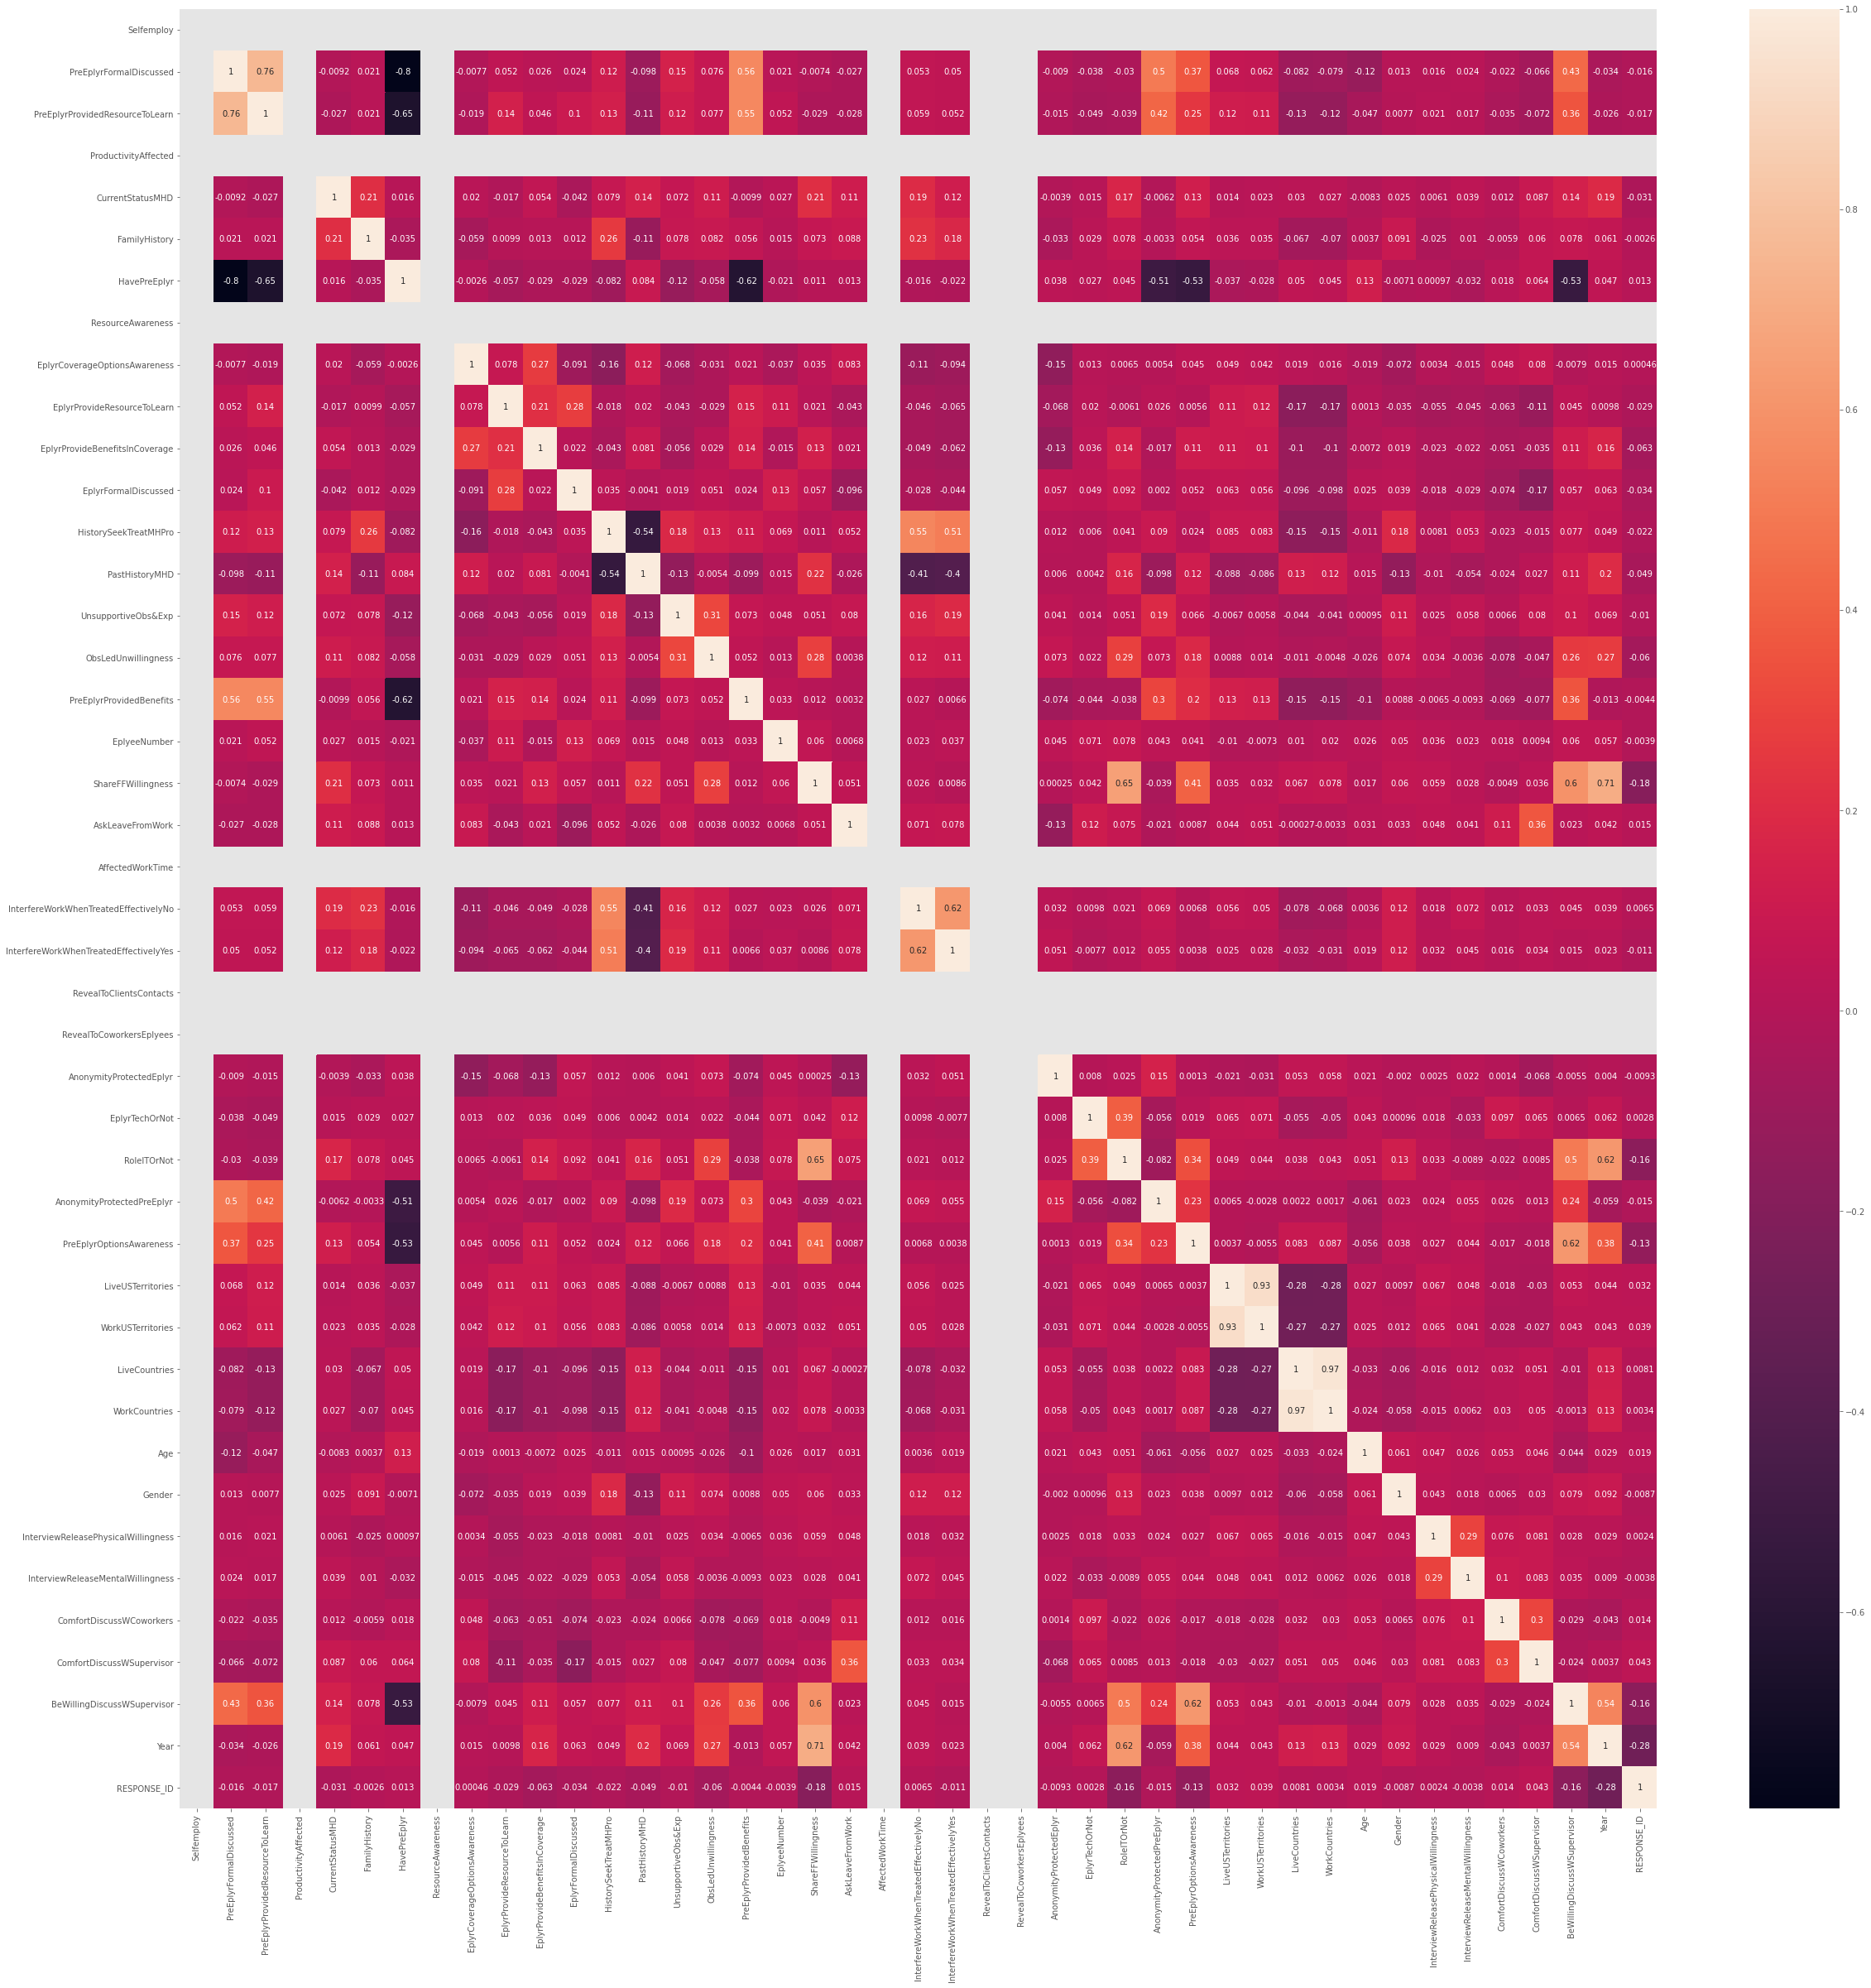

In [33]:
test=final_osmi_nna.copy()
plt.figure(figsize=(40,40))
numeric_data=test.apply(lambda x: x.factorize()[0])
cr=test.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(cr,annot=True);

b) The next step is to filter out the variables that we want to use in the machine learning model. Here we are using'corelation >0.1' as our criteria.
We also dropped the feature 'Year' from the list as it doesn't make any sense in this case

In [0]:
features=cr.iloc[4]
features[features>0.1].index
X_list=['FamilyHistory', 'PastHistoryMHD',
       'ObsLedUnwillingness', 'ShareFFWillingness', 'AskLeaveFromWork',
       'InterfereWorkWhenTreatedEffectivelyNo',
       'InterfereWorkWhenTreatedEffectivelyYes', 'RoleITOrNot',
       'PreEplyrOptionsAwareness', 'BeWillingDiscussWSupervisor']

X=numeric_data[X_list]
y=numeric_data['CurrentStatusMHD']

c) As this is a multi-class classification, we can not use any model we covered in class which focuses mainly on binary classification, here we picked the OneVsOneClassfier:
https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html

In [35]:
X_train,X_test,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=34)
OVO=OneVsOneClassifier(LinearSVC(random_state=34)).fit(X_train,ytrain)
y_model=OVO.predict(X_test)

accuracy_score(ytest,y_model)

0.6863543788187373

d) We then want to explore a binary model by converting respondents other than 'Yes' to 'Other':

In [36]:
#Yes equals to 1 in the series 
y[y!=1]=0

X_train,X_test,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=34)
model=LogisticRegression()
model.fit(X_train,ytrain)
y_model=model.predict(X_test)

accuracy_score(ytest,y_model)


0.8228105906313645

e) Calculate the true positive rate for the logistic model:

In [37]:
#Also in this case, we can check the TPR(True positive rate) to see if the model is accurate in identifying those with potential MHD

TP=len(ytest[ytest==1])
TP

P=len(ytest[(ytest==1)&(y_model==1)])
P

TPR=P/TP

print('The true positive rate of this model is:',TPR)

The true positive rate of this model is: 0.8217821782178217


<a id = "appendix_a"></a>
# <u>Appendix A</u>

[Back to Project Overview](#project_overview)

## OSMI Survey Questions:

- Are you self-employed?
- How many employees does your company or organization have?
- Is your employer primarily a tech company/organization?
- Is your primary role within your company related to tech/IT?
- Does your employer provide mental health benefits as part of healthcare coverage?
- Do you know the options for mental health care available under your employer-provided coverage?
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
- Does your employer offer resources to learn more about mental health concerns and options for seeking help?
- Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
- If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
- Do you think that discussing a mental health disorder with your employer would have negative consequences?
- Do you think that discussing a physical health issue with your employer would have negative consequences?
- Would you feel comfortable discussing a mental health disorder with your coworkers?
- Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?
- Do you feel that your employer takes mental health as seriously as physical health?
- Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?
- Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?
- Do you know local or online resources to seek help for a mental health disorder?
- If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?
- If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?
- If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?
- If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?
- Do you believe your productivity is ever affected by a mental health issue?
- If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?
- Do you have previous employers?
- Have your previous employers provided mental health benefits?
- Were you aware of the options for mental health care provided by your previous employers?
- Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?
- Did your previous employers provide resources to learn more about mental health issues and how to seek help?
- Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?
- Do you think that discussing a mental health disorder with previous employers would have negative consequences?
- Do you think that discussing a physical health issue with previous employers would have negative consequences?
- Would you have been willing to discuss a mental health issue with your previous co-workers?
- Would you have been willing to discuss a mental health issue with your direct supervisor(s)?
- Did you feel that your previous employers took mental health as seriously as physical health?
- Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?
- Would you be willing to bring up a physical health issue with a potential employer in an interview?
Why or why not?
- Would you bring up a mental health issue with a potential employer in an interview?
Why or why not?
- Do you feel that being identified as a person with a mental health issue would hurt your career?
- Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?
- How willing would you be to share with friends and family that you have a mental illness?
- Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
- Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?
- Do you have a family history of mental illness?
- Have you had a mental health disorder in the past?
- Do you currently have a mental health disorder?
- If yes, what condition(s) have you been diagnosed with?
- If maybe, what condition(s) do you believe you have?
- Have you been diagnosed with a mental health condition by a medical professional?
- If so, what condition(s) were you diagnosed with?
- Have you ever sought treatment for a mental health issue from a mental health professional?
- If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?
- If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
- What is your age?
- What is your gender?
- What country do you live in?
- What US state or territory do you live in?
- What country do you work in?
- What US state or territory do you work in?
- Which of the following best describes your work position?
- Do you work remotely?
